In [1]:
### # Initial Code source by:                Gaël Varoquaux
#                                        Andreas Müller
# Modified for documentation by:         Jaques Grobler
# Mainly Modified for private usage by:  Ioannis Agriomallos
# License: BSD 3 clause
####################################################################################################################
######==================== CURRENT CODE USAGE ======================================================================
# -> Current code trains several ML Classifiers, to classify force input samples as stable (0) or slip (1)
######---- Input
# -> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 3 different datasets, 
# containing several surfaces as well as slip-stable occurrences
######---- Input transformation
# -> Several pre-features are taken from these inputs.
# -> Several time and frequency domain features are extracted from pre-feature windows. 
# (implemented in 'newfeatext.py') These windows have size w and are shifted by s on each sample
# -> Then a feature selection-ranking is performed using MutualVariableInformation
# -> Finally PCA is performed to keep the desired among the best selected features
######---- Training of ML Classifiers
# -> Several ML Classifiers are trained for all combinations of features-datasets
######---- Stats report
# -> Several stats are reported on the classification results of the trained models, 
# based on their accuracy (fscore and auc as well) on test data as well as previously unseen data
######===================== POTENTIAL CODE EXTENSION FOR FURTHER MORE GENERIC USAGE ================================
# -> As binary classification problem it may apply to all such problems given that:
######----- Input
# -> Input is loaded on datasets, which expect (n,1) input with (k,4) dimensions each,
# where n data samples, k measurement in each sample, 3 force readings and 1 label for each measurement.
######----- Input transformation
# -> Pre-features must be changed or ommitted to fit your needs. 
# Here they served to transform the 3 (fx,fy,fz) force readings into one between (ft,fn,ft/fn,sf)
# -> Features are performed on the desired pre-features. They take a (n,o,m) input matrix and return a (n,o,l),
# where n data samples, o windows, m prefeatures, l features.
# -> Feature selection gives a ranking on each l, so we keep b from the best
# -> PCA is performed on the b selected features resulting in p dimensions (n,o,p) => (n*o,p)
######----- Training of ML Classifiers
# -> Each Classifier is trained on a subset of (n*o,p)
######----- Stats
# -> Change accordingly!
####################################################################################################################
print(__doc__)
import time
start_time = time.time()
from copy import deepcopy, copy
import math
import scipy.io as sio
import shutil
import os
from random import shuffle
import numpy as np
from pylab import *
from featext2 import *
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D #, axes3d
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, ParameterGrid, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RandomizedLasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif, SelectFdr
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from collections import OrderedDict
import re
import datetime
import urllib
import tarfile
import joblib
from joblib import Parallel, delayed, Memory
from tempfile import mkdtemp
import copy_reg
import types
import itertools
import pywt
from scipy import signal
from scipy.signal import lfilter, butter
from numpy.fft import fft, fftfreq, rfft

#import multiprocessing
def _pickle_method(m):
    if m.im_self is None:
        return getattr, (m.im_class, m.im_func.func_name)
    else:
        return getattr, (m.im_self, m.im_func.func_name)
copy_reg.pickle(types.MethodType, _pickle_method)

h = .2  # step size in the mesh

# datapath = 'tmp/'
# featpath = datapath+'features/'

# names = ["NearNb", "LinSVM", "RBFSVM", "NaiveBayes", "LDA",
#          "QDA", "MLP", "Lasso", "Lin.Regr", "Log.Regr", "Dec.Tree",
#          "RandFor", "AdaBoost", "EnsembleMLP"]
# names = ["NearNb", "RBFSVM1", "RBFSVM2", "NaiveBayes", "LDA",
#          "QDA", "MLP1", "MLP2", "Lasso", "Lin.Regr", "Log.Regr", "Dec.Tree",
#          "RandFor", "AdaBoost", "EnsembleMLP"]
# names = ["NearNb", "LINSVM1", "RBFSVM1", "NaiveBayes", "LDA",
#          "QDA", "MLP1", "Lasso", "Lin.Regr", "Log.Regr", "Dec.Tree",
#          "RandFor", "AdaBoost", "EnsembleMLP"]
# names = ["NearNb", "RBFSVM1", "NaiveBayes", "MLP1", "Log.Regr", "RandFor", "AdaBoost", "EnsembleMLP"]
names = ["NearNb", "RBFSVM1", "MLP1", "RandFor", "EnsembleMLP"]
classifiers = [
    KNeighborsClassifier(5),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
    SVC(gamma='auto', C=1),
#     SVC(gamma='auto', C=100),
#     GaussianNB(),
#     LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
#     MLPClassifier(solver='lbfgs',alpha=1e-1,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
#     MLPClassifier(solver='adam',epsilon=1e-5,alpha=1e-4,hidden_layer_sizes=(50,50),random_state=1,verbose=False),
#     MLPClassifier(solver='adam',epsilon=1e-5,alpha=1e-1,hidden_layer_sizes=(50,50),random_state=1,verbose=False),
#     LassoCV(),
#     LinearRegression(),
#     LogisticRegression(),
#     DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     AdaBoostClassifier(),
#     MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(len(names)-1,2),random_state=1,max_iter=500)
    MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(len(names)-1,len(names)-1),random_state=1,max_iter=500)
    #VotingClassifier()
]

# classifiers = [SVC(),KNeighborsClassifier()]
cv = StratifiedKFold(n_splits=5, random_state=42)
# params = []


parameters_clf = [{'n_neighbors':[4,7,9,12]},
#               {},
              {'kernel':['rbf'], 'C':[0.1,10,100,1000]},
#               {},
#               {},
#               {},
              {'solver':['lbfgs'], 'alpha':[1e-5,1e-2], 'hidden_layer_sizes':[(10,10),(50,50)]},
#               {},
#               {},
#               {},
#               {'max_depth':[4,5,6,8,10]},
              {'max_depth':[4,7,10,20],'n_estimators':[5,10,20],'max_features':[20,35,50]}
#               {},
#               {'solver':['lbfgs'], 'alpha':[1e-5], 'hidden_layer_sizes':[(len(names)-1,len(names)-1),(len(names)-1,2)]}
             ]
makepipe_parameters_clf = [{'classifier__'+key:p[key] for key in p} for p in parameters_clf]
makepipe_parameters_clf += [{'feature_selection__k': (750,500,100), 'feature_selection__score_func': [mutual_info_classif]},
                            {'decomp__n_components': (100,50)}]

# print makepipe_parameters_clf


metric = ['accuracy','f1']
dataset = 0 # all datasets (0), dataset 1-2 (1), dataset 3 (2), dataset4 (3)
download = 1 # Download pre-computed (1) data or compute them anew (0)

Automatically created module for IPython interactive environment


In [2]:
######################################## INITIALISATION PARAMETERS #################################################
window, shift, keepfromshift = 1024, 20, 10
samplesperdataset = 10000
havelabel = 1
returntime = 0
featlabel = 0         # 0: all features, 1: temporal, 2: frequency, 3: FFT only
magnFFT = 0           # 0: FFT in magnitude format, 1: FFT in real and imag format, 
featall = 0           # 0: all, 1: feat1 (phinyomark's), 2: feat2 (golz's)
featparam = [havelabel,featlabel,magnFFT,featall,returntime]
metr = metric[0]      # 0: accuracy, 1: f1score
CV = 5                # cross validation checks
prefeatid = [0,3,4]   # only the prefeatures with corresponding ids will be computed
datapath = 'tmp/'
featpath = datapath+'features/'+str(window)+'_'+str(shift)+'/'
numfeat = 10 # number of features to show
nfeat = 1000 # number of features to keep

In [3]:
########################################## Download necessary files ################################################
# if download==1:
#     downpath = featpath
#     downfile = downpath+"features.tar.gz"
#     downlink = "https://www.dropbox.com/s/lx3ggezzq2wl2km/features.tar.gz?dl=1"
#     if not os.path.isfile(downfile):
#         u = urllib.urlopen(downlink)
#         data = u.read()
#         print 'Completed downloading ',len(data)*1./(1024**3),'GB of ',downfile,'!'
#         u.close()
#         with open(downfile, "wb") as f :
#             f.write(data)
#     else:
#         print 'Necessary ',downfile,'  already here!'
#     print 'Extracting files...'
#     directory = featpath
#     def extract_nonexisting(archive):
#         for name in archive.getnames():
#             if os.path.exists(os.path.join(directory, name)):
#                 print name, "already exists"
#             else:
#                 archive.extract(name, path=directory)
#     archives = [name for name in os.listdir(directory) if name.endswith("tar.gz")]
#     for archive_name in archives:
#         with tarfile.open(featpath+archive_name) as archive:
#             extract_nonexisting(archive)
# #     if (downfile.endswith("tar.gz")):
# #         tar = tarfile.open(downfile, "r:gz")
# #         tar.extractall(path=downpath)
# #         tar.close()
#     print 'Completed extracting files!'
########################################## Download necessary datasets #############################################
# datafiles1 = datapath+'slipdataset12_trunc.mat'
# if not os.path.isfile(datafiles1):
#     downdata1 = "https://www.dropbox.com/s/w8y0rlg9kj6axxt/slipdataset12.mat?dl=1"
#     u = urllib.urlopen(downdata1)
#     data = u.read()
#     print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafiles1,'!'
#     u.close()
#     with open(datafiles1, "wb") as f :
#         f.write(data)
# else:
#     print 'Necessary ',datafiles1,' already here!'
# datafiles2 = datapath+'slipdataset3_C.mat'
# if not os.path.isfile(datafiles2):
#     downdata2 = "https://www.dropbox.com/s/95znajbu6sga8iz/slipdataset3_C.mat?dl=1"
#     u = urllib.urlopen(downdata2)
#     data = u.read()
#     print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafiles2,'!'
#     u.close()
#     with open(datafiles2, "wb") as f :
#         f.write(data)
# else:
#     print 'Necessary ',datafiles2,' already here!'
# datafiles3 = datapath+'allsurffinal.mat'
# if not os.path.isfile(datafiles3):
# #     downdata2 = "https://www.dropbox.com/s/95znajbu6sga8iz/slipdataset3_C.mat?dl=1"
# #     u = urllib.urlopen(downdata2)
# #     data = u.read()
# #     print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafiles2,'!'
# #     u.close()
# #     with open(datafiles2, "wb") as f :
# #         f.write(data)
#     print 'Necessary ',datafiles3,' not here! DO SOMETHING ABOUT IT!'
# else:
#     print 'Necessary ',datafiles3,' already here!'
datafiles4 = datapath+'all123.npz'
# datafiles5 = datapath+'test1.npz'
datafiles6 = datapath+'data4.npz'
########################################## Download pretrained ML Classifiers models ###############################    
clfmodelfile = datapath+'trained_classifiers_newdata1and2_NOsample_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)+'.npz'
modelfile = datapath+'allmodels_newdata1and2_NOsample_'+str(window)+'_'+str(shift)+'.npz'

featname = 'newfeatures_newdata1and2_NOsample_transtart'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
featfile = featpath+featname+'.npz'
XYfile = featpath+featname+'_XY.npz'
XYnormfile = featpath+featname+'_XYnorm.npz'
# if not os.path.isfile(clfmodelfile):
#     downclf = "https://www.dropbox.com/s/po9m048ukqt1ahn/trained_classifiers.npz?dl=1"
#     u = urllib.urlopen(downclf)
#     data = u.read()
#     print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',clfmodelfile,'!'
#     u.close()
#     with open(clfmodelfile, "wb") as f :
#         f.write(data)
# else:
#     print clfmodelfile,' already here!'

In [4]:
########################################## READ THE DATASETS #######################################################
# ####################### DATASET 1-2, including slip instances for pillbox object ###################################
# inp = sio.loadmat(datafiles1,struct_as_record=True)
# f1 = inp['f1'] # 1st optoforce
# # f2 = inp['f2'] # 2nd optoforce
# l1 = inp['label1'] # corresponding labels
# # l2 = inp['label2']
# f1d = inp['detail1'] # summary of each dataset 
# lmat1 = np.zeros(f1.shape[0]) # material label
# print 1,f1.shape, l1.shape, f1d.shape, lmat1.shape
# ################ DATASET 3, including slip instances for several surfaces (see f3d for details) ####################
# inp3 = sio.loadmat(datafiles2,struct_as_record=True)
# f3 = inp3['f3'] # 1st optoforce
# f3 = np.array([fi[0][:,:-1] for fi in f3])[:,np.newaxis]
# l31 = inp3['label3_cmd'] # corresponding label from commanded slip (1) or stay (0)
# l32 = inp3['label3_vel_norm'] # corresponding measured tip velocity
# l32 = np.array([ln[0]/np.max(ln[0]) for ln in l32])[:,np.newaxis]
# # l33 = inp['label3_acc'] # corresponding measured tip acceleration
# f3d = inp3['detail3'] # summary of each dataset
# lmat3 = np.array([1,2,2,2,3,2,4]) # material label, for dataset3
# print 2,f3.shape, l31.shape, f3d.shape, lmat3.shape
# ################ DATASET 4, including slip instances for several surfaces (see  for details) ####################
# inp4 = sio.loadmat(datafiles3,struct_as_record=True)
# f4 = inp4['final'] # optoforce of 2nd finger (data_format: 'experiment phase stay(1)/slip(0) fx fy fz vx vy vz')
# l41 = np.array([1-fi[0][:,2][:,np.newaxis] for fi in f4])[:,np.newaxis] # commanded slip or stay
# l42 = np.array([np.linalg.norm(fi[0][:,6:],axis=1)[:,np.newaxis]/np.max(np.linalg.norm(fi[0][:,6:],axis=1)[:,np.newaxis])
#                 for fi in f4])[:,np.newaxis] # slip or stay extracted from velocity
# f4d = inp4['surf_name'][:,0][:,np.newaxis]
# lmat4 = inp4['surf_lab'][:,0]
# f4 = np.array([fi[0][:,3:6] for fi in f4])[:,np.newaxis]
# print 3,f4.shape, l41.shape, l42.shape, f4d.shape, lmat4.shape
# plt.figure(0)
# plt.plot(l41[0][0])
# plt.hold
# plt.plot(l42[0][0])
# l42accel = l42[0][0][1:]-l42[0][0][:-1]
# plt.plot(l42accel)
# plt.scatter(range(l42accel.shape[0]),l42accel>0.1)
###
inp = np.load(datafiles4)
f1 = inp['f1']
l1 = np.array([fi[:,1] for fi in f1[:-1]])
f1 = np.array([fi[:,2:] for fi in f1[:-1]])
f2 = inp['f2']
l2 = np.array([fi[:,1] for fi in f2[:-1]])
f2 = np.array([fi[:,2:] for fi in f2[:-1]])
details = inp['details']
f1d = details[:-1]
f2d = details[:-1]
print 1,f1.shape, l1.shape, f1d.shape
print 2,f2.shape, l2.shape, f2d.shape
# inpt = np.load(datafiles5)
# f1t = inpt['f1']
# l1t = np.array([fi[:,1] for fi in f1t])
# f1t = np.array([fi[:,2:] for fi in f1t])
# f2t = inpt['f2']
# l2t = np.array([fi[:,1] for fi in f2t])
# f2t = np.array([fi[:,2:] for fi in f2t])
# details = inpt['details']
# f1td = details
# f2td = details
# print 1,f1t.shape, l1t.shape, f1td.shape
# print 2,f2t.shape, l2t.shape, f2td.shape
inptn = np.load(datafiles6)
f1tn = inptn['f1']
l1tn = np.array([fi[:,1] for fi in f1tn])
f1tn = np.array([fi[:,2:] for fi in f1tn])
f2tn = inptn['f2']
l2tn = np.array([fi[:,1] for fi in f2tn])
f2tn = np.array([fi[:,2:] for fi in f2tn])
details = inptn['details']
f1tdn = details
f2tdn = details
print 1,f1tn.shape, l1tn.shape, f1tdn.shape
print 2,f2tn.shape, l2tn.shape, f2tdn.shape
########################################### MERGE THE DATASETS #####################################################
if dataset == 0: # use both datasets
#     f = np.concatenate((f1,f2,f1t,f2t,f1tn,f2tn),axis=0)
#     l = np.concatenate((l1,l2,l1t,l2t,l1tn,l2tn),axis=0)
#     fd = np.concatenate((f1d,f2d,f1td,f2td,f1tdn,f2tdn),axis=0)
    f = np.concatenate((f1,f1tn,f2,f2tn),axis=0)
    l = np.concatenate((l1,l1tn,l2,l2tn),axis=0)
    fd = np.concatenate((f1d,f1tdn,f2d,f2tdn),axis=0)
elif dataset == 1:  # use dataset for finger 1
    f = f1tn
    l = l1tn
    fd = f1tdn
elif dataset == 2:  # use dataset for finger 2
    f = f2tn
    l = l2tn
    fd = f2tdn
print 3,f.shape,l.shape
####################################### INDECES for dataset 1-2 ####################################################
# all indeces
# ind = range(f.shape[0])
# # indexes for rolling
# indroll = [16,17,21,22] # during pure stable dataset
# # indexes for disturbance
# inddist = [12,26]       # ind:12 for pure stable and ind:26 for pure slip dataset 
# # indexes for rotation
# indrot = [25,31]        # during pure slip dataset
# # indexes for circular induced slippage
# indcirc = [32,33]       # during pure slip dataset
# # kept indeces
# if dataset == 0:
#     nind = np.delete(ind,indroll+inddist)#+indrot+indcirc)
#     nind = np.delete(nind,[33])
#     # indexes of steady-state slip or stable
#     indssbl = [0,1,2,3,12,13,14,15,16,17]
#     indsslp = [18,19,20,21,22,23,24,25,26,27]
#     nind = np.delete(nind,indssbl+indsslp) # remove the steady-state slip or stable indeces
# else:
nind = range(f.shape[0])
f = f[nind]
l = l[nind]
fd = fd[nind]
print 4, f.shape, l.shape
# membership of each sample, representing its portion in the dataset
# member = np.zeros(len(f))
# m1,m2 = len(nind)-len(f2),len(f2)
# member[:m1] = np.ones(m1)*1./m1
# member[-m2:] = np.ones(m2)*1./m2
# print 5,m1,m2,sum(member[:m1]),sum(member[-m2:])
member = np.zeros(len(f))
# m1,m2,m3 = len(f1tn), len(f2tn), len(f1tn)+len(f2tn)
m1,m2 = len(f1tn)+len(f1), len(f2tn)+len(f2)
member[:m1] = np.ones(m1)*1./m1
# member[m1:-m3] = np.ones(m2)*1./m2
member[-m2:] = np.ones(m2)*1./m2
print 5,m1,m2,sum(member[:m1]),sum(member[-m2:])
########################################### MERGE f and l ##########################################################
f = np.array([np.concatenate((f[i],l[i][:,np.newaxis]),axis=1) for i in range(len(f))])
# f = np.delete(f,[33])
# fd = np.delete(fd,[33])
print 6,f.shape,":",[fi.shape for fi in f]
########################################################
f = np.array([fi[::1,:] for fi in f]) # subsampling ###
########################################################
print 7,f.shape,":",[fi.shape for fi in f]
forcename = 'forces_NOsample_data1and2'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
forcefile = featpath+forcename+'.npz'
np.savez(forcefile,f=f,fd=fd)
# plt.figure(1)
# plt.plot(f[33])
# plt.hold
# plt.plot(l42[4,0])

1 (18,) (18,) (18, 4, 1)
2 (18,) (18,) (18, 4, 1)
1 (18,) (18,) (18, 4, 1)
2 (18,) (18,) (18, 4, 1)
3 (72,) (72,)
4 (72,) (72,)
5 36 36 1.0 1.0
6 (72,) : [(345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (130001, 4), (195001, 4), (65001, 4), (345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001,

In [5]:
# # plt.plot(f[0])
# # Preparing f1 and f2 datasets with Low Pass Butterworth

# # determine filter's parameters 
# fnyquist = 0.5
# fc = 0.18/fnyquist

# b, a = signal.butter(4,fc,'low')
# w,h = signal.freqs(b,a)
# tbf_f1 = deepcopy(f1)
# tbf_f2 = deepcopy(f2)
# tbf_f = deepcopy(f)
# lp_f1 = []
# lp_f2 = []
# lp_f = []
# for i in range(len(tbf_f1)):
#     lp_f1.append(lfilter(b,a,tbf_f1[i], axis = 0))
#     lp_f2.append(lfilter(b,a,tbf_f2[i], axis = 0))
# for i in range(len(tbf_f)):
#     lp_f.append(lfilter(b,a,tbf_f[i], axis = 0))
# for i in range(len(tbf_f)):
#     lp_f[i][:,-1] = f[i][:,-1]
# lp_f = np.array(lp_f)

In [6]:
def make_pipe_clf(scaler,feature_selection,decomp,clf):
    order = 1
# order = 1 : first perform feature selection and then apply PCA
# order = 0 : first apply PCA and then reduce the transformed features
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                    ('classifier', clf) ])
#     else:
#         pipeline = Pipeline([('scaler', scaler),
#                     ('decomp', decomp ),                 
#                     ('feature_selection', feature_selection),        
#                     ('classifier', clf) ])
    return pipeline
###########################################################################################
def make_pipe(scaler,feature_selection,decomp,order):
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                     ])
    else:
        pipeline = Pipeline([('scaler', scaler),
                    ('decomp', decomp ),                 
                    ('feature_selection', feature_selection),        
                     ])
    return pipeline

In [7]:
def gs_fun(clf,params,cv,x,y):
    grid_search = GridSearchCV(estimator=clf,param_grid= params, cv = cv, n_jobs=-1, verbose = 0)
    grid_search.fit(x,y)
    print("------ Grid search cv results for %0.8s ------" %clf)
    print("Best score: %0.4f" %grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
         print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return best_parameters, grid_search.best_estimator_

In [8]:
def ftran(i,f,history=100):
# Rotation of measured force wrt to contact normal frame
# Estimation of normal force at contact point assuming f
# is very close to the middle of the friction cone
    print i
    l = f[history:,-1]
    f = f[:,:-1]
    nfo = np.zeros(f[history:,:].shape)
    z = np.array([0, 0, 1])
    lastnfo = z
    currnfo = z
    retf = np.zeros(f[history:,:].shape)
#     nfo = [np.mean(f[i-history:i,:],axis=1) for i in range(len(f)) if sum(l[i-history:i]) == 0 and i>=history]  
    for i in range(len(f)):
        if i>=history:
#             print l.shape
#             print np.sum(l[i-history:i])
            if np.sum(l[i-history:i]) == 0:
                currnfo = np.mean(f[i-history:i,:],axis=0)
#                 print currnfo.shape
                currnfo /= np.linalg.norm(currnfo)
                lastnfo = currnfo
            else:
                currnfo = lastnfo
            nfo[i-history] = currnfo

            if sum(currnfo == z) == 3 or sum(currnfo == -z) == 3:
                R_cb = np.eye(3)
            else:
                R_cb = np.zeros((3, 3))
                R_cb[:, 2] = currnfo
                R_cb[:, 0] = np.cross(currnfo, z)  # x' = nfo x z
                R_cb[:, 0] = R_cb[:, 0]*1./np.sqrt(sum(np.power(R_cb[:, 0], 2)))
                R_cb[:, 1] = np.cross(currnfo, R_cb[:, 0])  # y' = nfo x x'
            R_bc = R_cb.transpose()
            newf = R_bc.dot(f[i,:])  # newf wrt contact normal's frame
            retf[i-history,:] = newf
    retf = np.concatenate((retf,l[:,np.newaxis]),axis=1)
    nfo = np.concatenate((nfo,l[:,np.newaxis]),axis=1)
    return retf, nfo

In [9]:
def ftranstart(i,f,history=100):
# Rotation of measured force wrt to contact normal frame
# Estimation of normal force at contact point assuming f
# is very close to the middle of the friction cone
    print i
    l = f[history:,-1]
    f = f[:,:-1]
    nfo = np.zeros(f[history:,:].shape)
    z = np.array([0, 0, 1])
#     lastnfo = z
#     currnfo = z
    currnfo = np.mean(f[:history,:],axis=0)
    currnfo /= np.linalg.norm(currnfo)
    retf = np.zeros(f[history:,:].shape)
#     nfo = [np.mean(f[i-history:i,:],axis=1) for i in range(len(f)) if sum(l[i-history:i]) == 0 and i>=history]  
    for i in range(len(f)):
        if i>=history:
#             print l.shape
#             print np.sum(l[i-history:i])
#             if np.sum(l[i-history:i]) == 0:
#             currnfo = np.mean(f[:history,:],axis=0)
# #                 print currnfo.shape
#             currnfo /= np.linalg.norm(currnfo)
#                 lastnfo = currnfo
#             else:
#                 currnfo = lastnfo
            nfo[i-history] = currnfo

            if sum(currnfo == z) == 3 or sum(currnfo == -z) == 3:
                R_cb = np.eye(3)
            else:
                R_cb = np.zeros((3, 3))
                R_cb[:, 2] = currnfo
                R_cb[:, 0] = np.cross(currnfo, z)  # x' = nfo x z
                R_cb[:, 0] = R_cb[:, 0]*1./np.sqrt(sum(np.power(R_cb[:, 0], 2)))
                R_cb[:, 1] = np.cross(currnfo, R_cb[:, 0])  # y' = nfo x x'
            R_bc = R_cb.transpose()
            newf = R_bc.dot(f[i,:])  # newf wrt contact normal's frame
            retf[i-history,:] = newf
    retf = np.concatenate((retf,l[:,np.newaxis]),axis=1)
    nfo = np.concatenate((nfo,l[:,np.newaxis]),axis=1)
    return retf, nfo

In [10]:
# i = 4
# plt.figure(figsize=(30,15))
# plt.subplot(3,1,1)
# tmp1 = f[i]
# plt.plot(tmp1/np.max(tmp1,axis=0))
# plt.subplot(3,1,2)
# tmp2 = ftran(f[i])[0]
# plt.plot(tmp2/np.max(tmp2,axis=0))
# plt.subplot(3,1,3)
# tmp3 = ftran(f[i])[1]
# plt.plot(tmp3/np.max(tmp3,axis=0))

In [11]:
########################################### PRE-FEATURES ###########################################################
############# DEFINITION
# featnum 0 : sf    = (fx^2+fy^2+fz^2)^0.5
#         1 : ft    = (fx^2+fy^2)^0.5
#         2 : fn    = |fz|
#         3 : ft/fn = (fx^2+fy^2)^0.5/|fz|
# input (nxm) -> keep (nx3) -> compute pre-feature and return (nx1)
# def fnormal(f,l):
#     return 0
# def ftranslate(f,fn):
#     return 0
def sf(f):
    return np.power(np.sum(np.power(f[:,:3],2),axis=1),0.5)
def ft(f):
    return np.power(np.sum(np.power(f[:,:2],2),axis=1),0.5)
def fn(f):
    return np.abs(f[:,2])
def ftn(f):
    retft = ft(f)
    retfn = fn(f)
    retft[retfn<=1e-2] = 0
    return np.divide(retft,retfn+np.finfo(float).eps)
def lab(f):
    return np.abs(f[:,-1])
prefeatfn = np.array([sf,ft,fn,ftn,lab]) # convert to np.array to be easily indexed by a list
############# COMPUTATION
prefeatname = 'newprefeatures_newdata1and2_transtart_NOsample'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
prefeatfile = featpath+prefeatname+'.npz'
# prefeatfname = 'newprefeaturesfxyz_trans_NOsample'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
# prefeatffile = featpath+prefeatfname+'.npz'

# prefeat = np.array([np.array([f[i] for prfn in prefeatfn[prefeatid]]) for i in range(len(f))])
prefeat = np.array([np.array([prfn(f[i]) for prfn in prefeatfn[prefeatid]]).transpose() for i in range(len(f))])
print prefeat.shape,":",[p.shape for p in prefeat]
############ FILTERED (Low-Pass) PREFEATURES
# newprefeat = np.array([np.array([prfn(lp_f[i]) for prfn in prefeatfn[prefeatid]]).transpose() for i in range(len(f))])
# print newprefeat.shape,":",[p.shape for p in newprefeat]
############ TRANSFORMED PREFEATURES
# newprefeat = np.array([np.array([ftran(f[i],l[i][0]) for prfn in prefeatfn[prefeatid]]) for i in range(len(f))])
def prefeatcomp(i,tmpf,pr):
#     print i, tmpf, pr
    return np.array([prfn(ftranstart(i,tmpf)[0]) for prfn in pr]).transpose()
    
if os.path.isfile(prefeatfile):
    newprefeat2 = np.load(prefeatfile)['newprefeat']
else:
#     tmp = np.array([Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])])
#     newprefeat2 = np.array([np.array([prfn(ftran(i,f[i])[0]) for prfn in prefeatfn[prefeatid]]).transpose() for i in range(len(f))])
#     newprefeat2 = np.array([prefeatcomp(i,f[i],prefeatfn[prefeatid]) for i in range(len(f))])
    newprefeat2 = np.array([Parallel(n_jobs=-1)([delayed(prefeatcomp) (i,f[i],prefeatfn[prefeatid]) for i in range(len(f))])])
    np.savez(prefeatfile,newprefeat=newprefeat2[0,:])
print newprefeat2.shape,":",[p.shape for p in newprefeat2]
# if os.path.isfile(prefeatffile):
#     newprefeatf = np.load(prefeatffile)['newprefeatf']
# else:
#     newprefeatf = np.array([ftran(f[i])[0] for i in range(len(f))])
#     np.savez(prefeatffile,newprefeatf=newprefeatf)
# # newprefeat = np.array([Parallel(n_jobs=-1)([delayed(function)(orisma)(np.array([prfn(ftran(f[i],l[i][0])) for prfn in prefeatfn[prefeatid]]).transpose()) for i in range(len(f))])])
# # np.array([Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])])
# print newprefeatf.shape,":",[p.shape for p in newprefeatf]

(72,) : [(345002, 3), (105001, 3), (210001, 3), (225002, 3), (130001, 3), (65001, 3), (195001, 3), (65001, 3), (130001, 3), (195001, 3), (65001, 3), (130001, 3), (225002, 3), (65001, 3), (130001, 3), (195001, 3), (65001, 3), (130001, 3), (75001, 3), (130001, 3), (195001, 3), (195001, 3), (130001, 3), (65001, 3), (65001, 3), (130001, 3), (195001, 3), (195001, 3), (130001, 3), (65001, 3), (65001, 3), (130001, 3), (195001, 3), (130001, 3), (195001, 3), (65001, 3), (345002, 3), (105001, 3), (210001, 3), (225002, 3), (130001, 3), (65001, 3), (195001, 3), (65001, 3), (130001, 3), (195001, 3), (65001, 3), (130001, 3), (225002, 3), (65001, 3), (130001, 3), (195001, 3), (65001, 3), (130001, 3), (75001, 3), (130001, 3), (195001, 3), (195001, 3), (130001, 3), (65001, 3), (65001, 3), (130001, 3), (195001, 3), (195001, 3), (130001, 3), (65001, 3), (65001, 3), (130001, 3), (195001, 3), (130001, 3), (195001, 3), (65001, 3)]
(72,) : [(344902, 3), (104901, 3), (209901, 3), (224902, 3), (129901, 3), (64

In [12]:
# angle of initial f wrt optoforce's z axis
phi = np.array([np.array([np.arctan(p[i,1]) for i in range(len(p[:,0])) if p[i,2]==0]) for p in prefeat])
print phi.shape,":",[p.shape for p in phi]

(72,) : [(165001,), (55000,), (110000,), (105001,), (70000,), (35000,), (105000,), (35000,), (70000,), (105000,), (35000,), (70000,), (105001,), (35000,), (70000,), (105000,), (35000,), (70000,), (35000,), (70000,), (105000,), (105000,), (70000,), (35000,), (35000,), (70000,), (105000,), (105000,), (70000,), (35000,), (35000,), (70000,), (105000,), (70000,), (105000,), (35000,), (165001,), (55000,), (110000,), (105001,), (70000,), (35000,), (105000,), (35000,), (70000,), (105000,), (35000,), (70000,), (105001,), (35000,), (70000,), (105000,), (35000,), (70000,), (35000,), (70000,), (105000,), (105000,), (70000,), (35000,), (35000,), (70000,), (105000,), (105000,), (70000,), (35000,), (35000,), (70000,), (105000,), (70000,), (105000,), (35000,)]


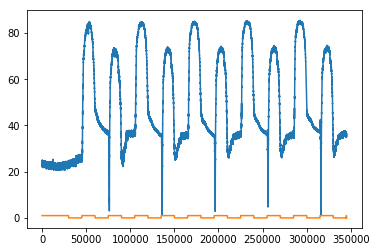

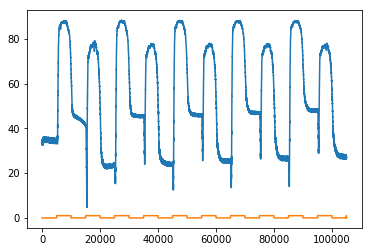

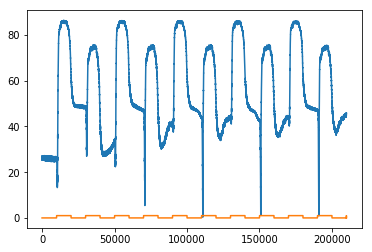

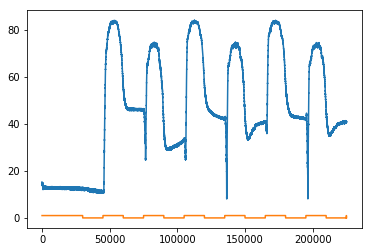

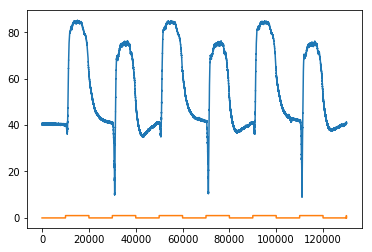

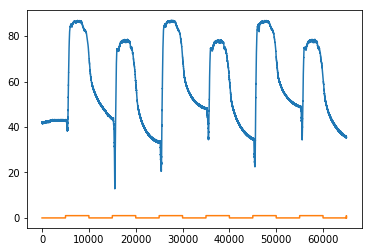

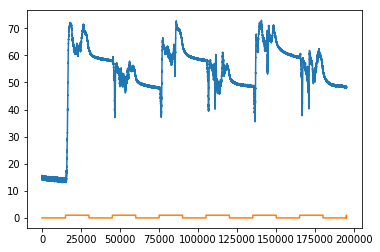

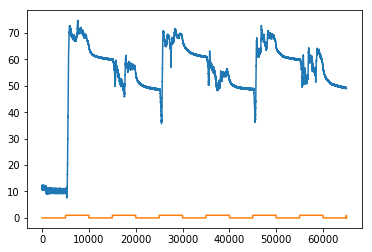

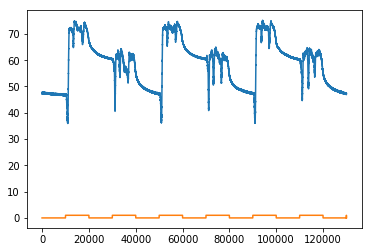

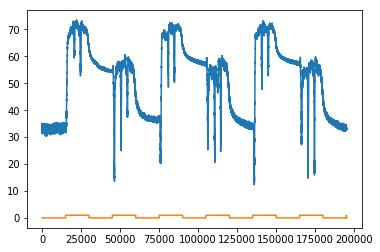

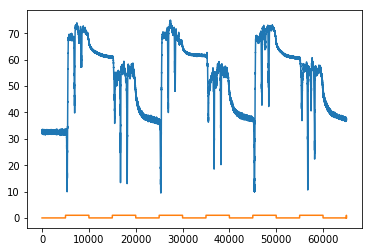

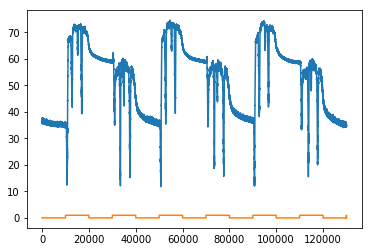

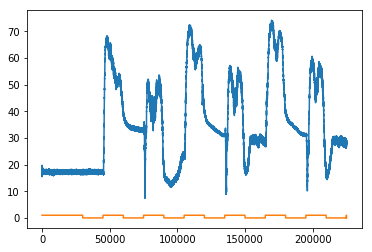

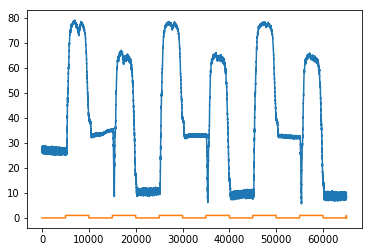

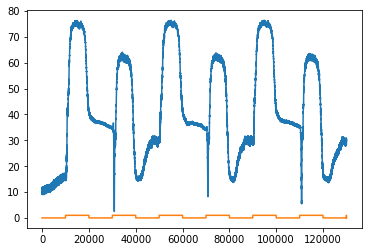

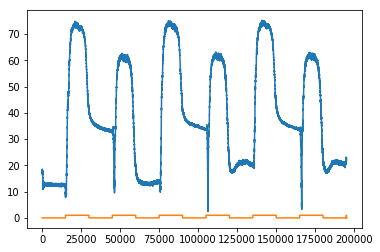

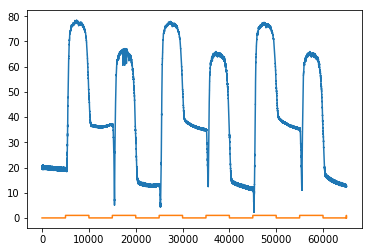

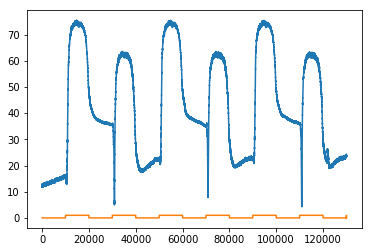

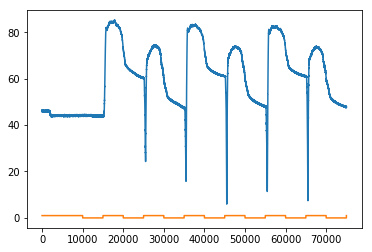

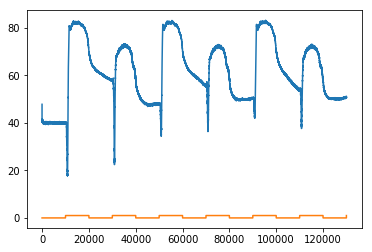

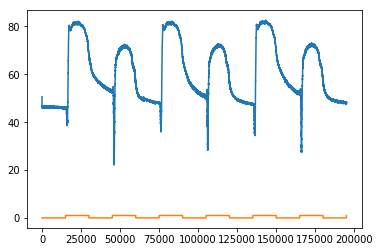

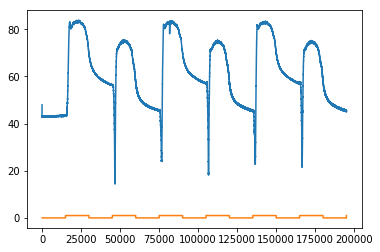

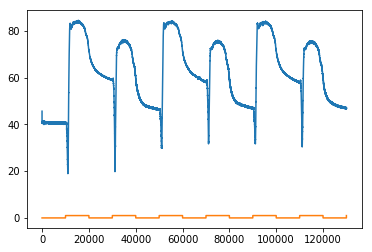

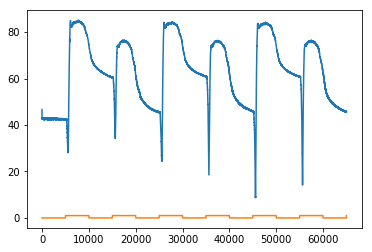

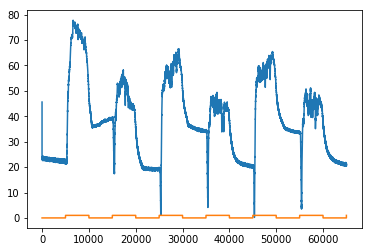

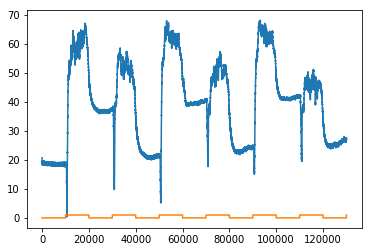

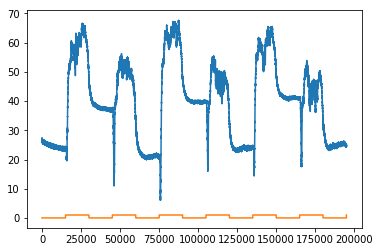

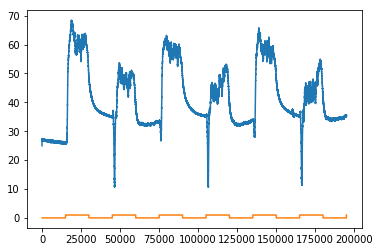

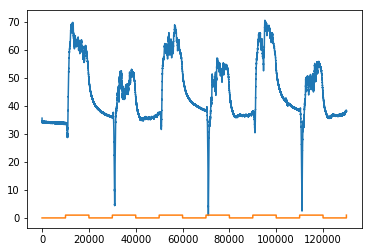

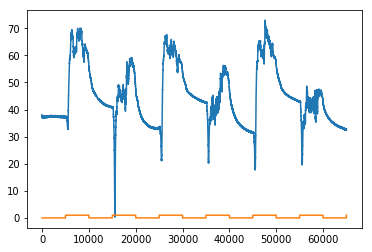

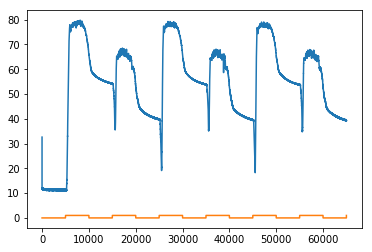

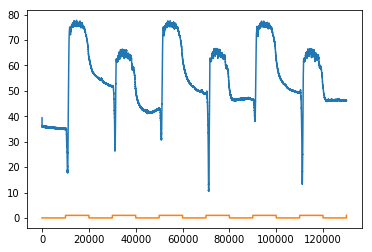

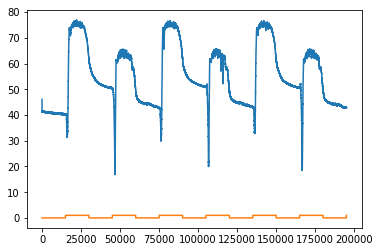

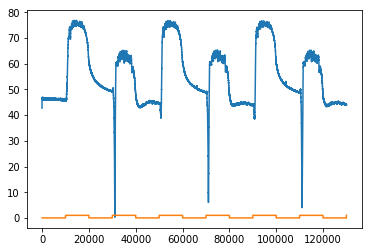

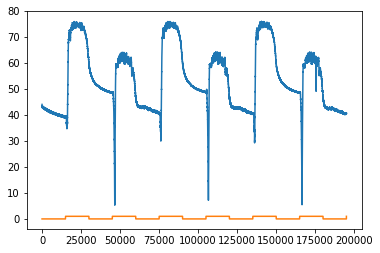

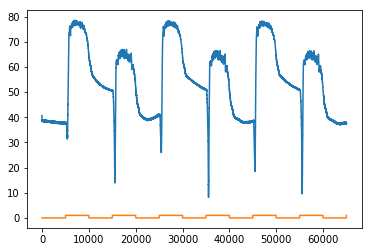

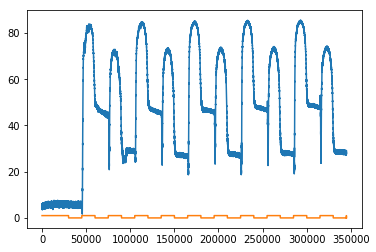

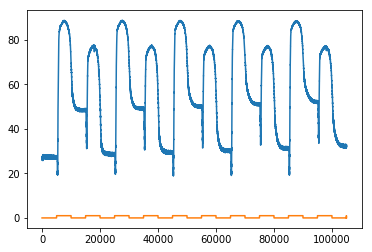

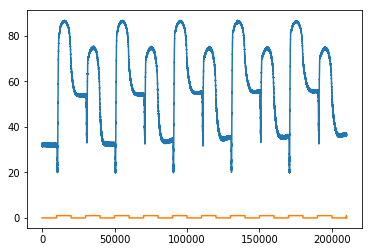

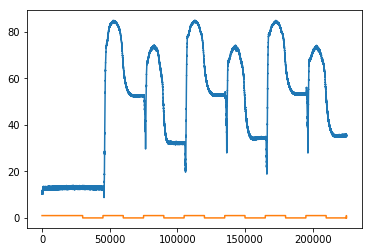

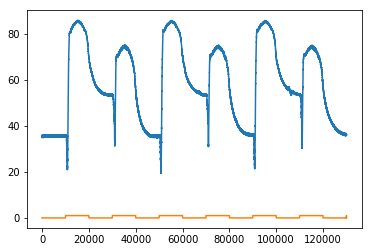

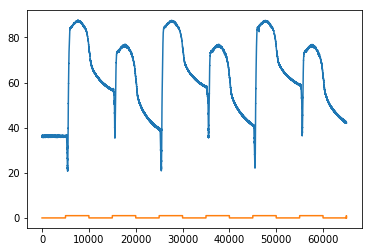

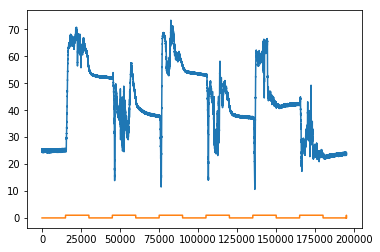

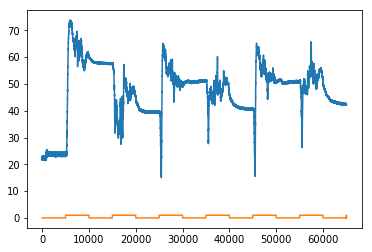

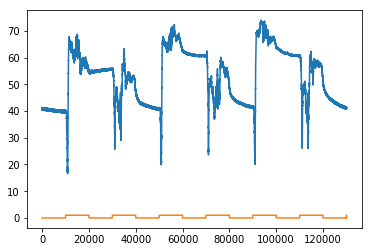

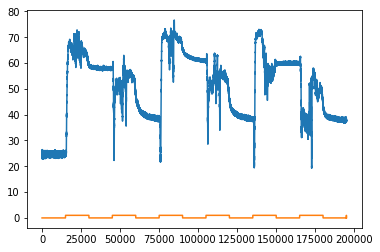

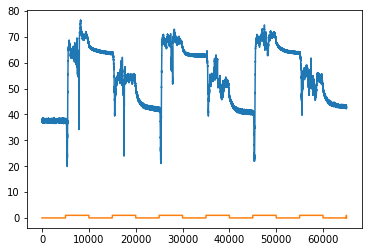

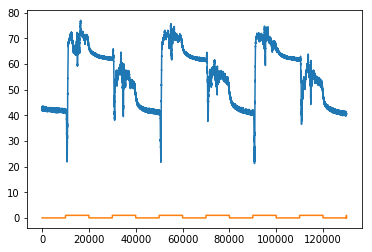

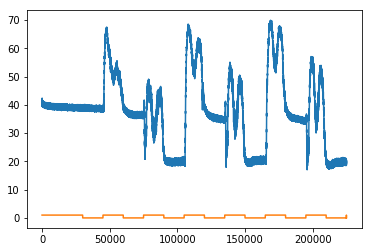

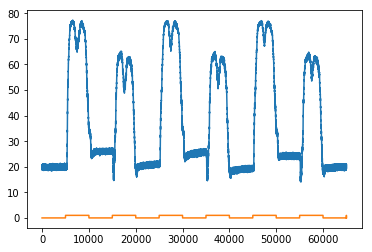

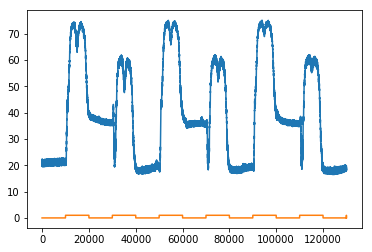

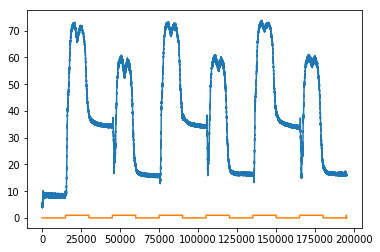

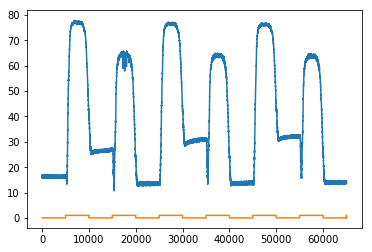

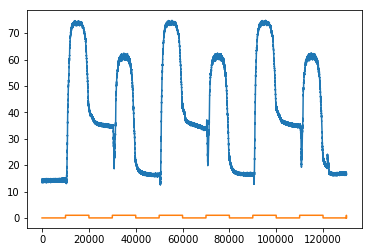

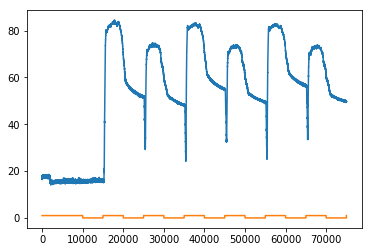

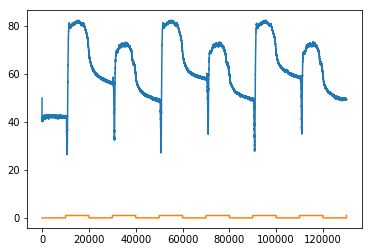

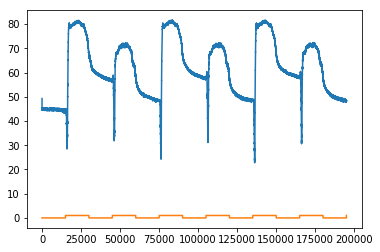

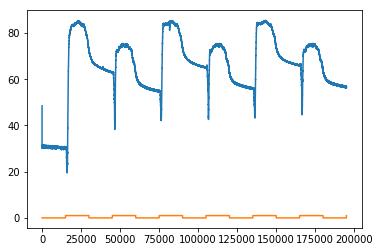

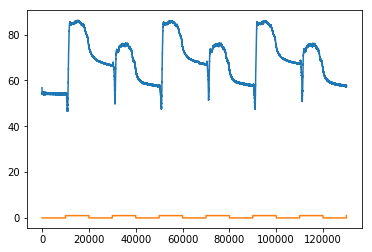

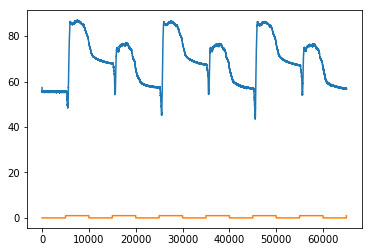

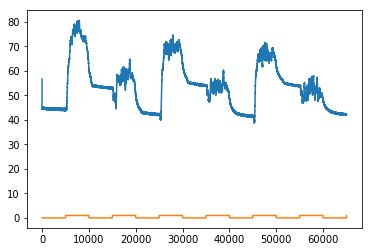

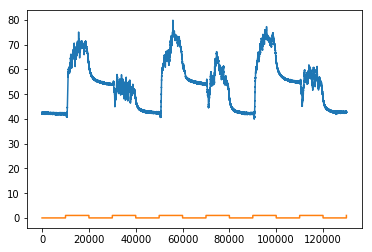

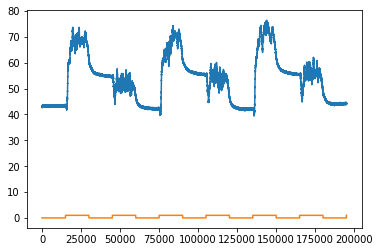

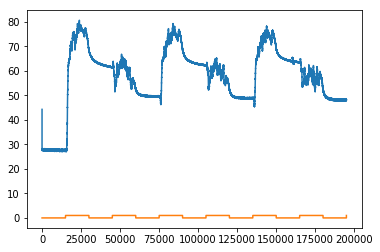

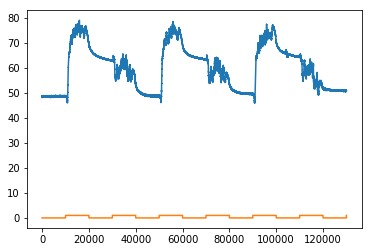

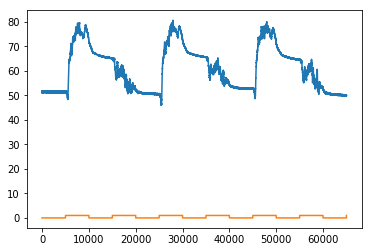

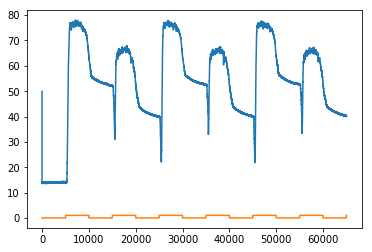

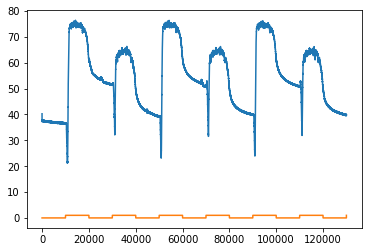

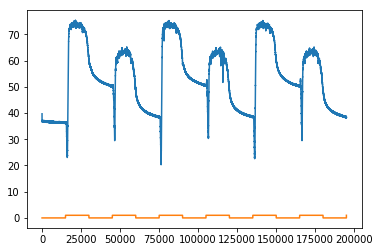

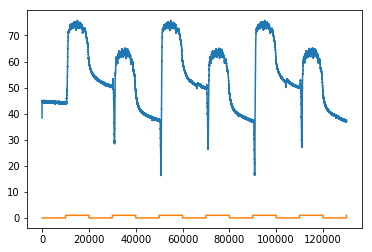

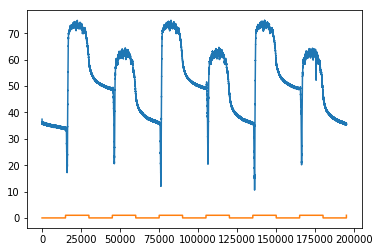

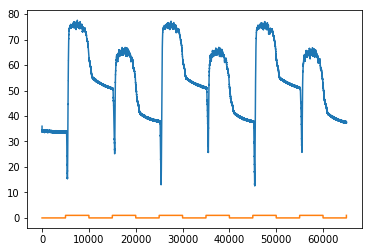

In [16]:
# plt.plot(phi[0])
for i in range(len(prefeat)):
    plt.figure()
    plt.plot(np.arctan(prefeat[i][:,1])*180/pi)
    plt.hold
    plt.plot(prefeat[i][:,2])
#     plt.hold
#     plt.plot(np.arctan(newprefeat2[0,i][:,1])*180/pi)

In [12]:
phi_mean_std = np.array([[np.mean(p)*180/pi,np.std(p)*180/pi] for p in phi])
print phi_mean_std
print np.mean(phi_mean_std,axis=0)

[[ 35.47093437   5.57314213]
 [ 37.52112703  10.88103042]
 [ 41.8798563    8.53167437]
 [ 36.46598135  11.47295406]
 [ 42.35388225   4.91774473]
 [ 46.48827443   8.01477795]
 [ 48.76541772  14.89246027]
 [ 49.25216977  16.78304066]
 [ 54.46885899   6.92036608]
 [ 45.44788892  11.31397696]
 [ 48.04563429  12.52357799]
 [ 47.12021704  11.58449795]
 [ 26.84182006   7.79708821]
 [ 22.37038848  11.30415706]
 [ 27.63904406   9.59657956]
 [ 24.7088639    9.82728581]
 [ 24.84077371  11.29611965]
 [ 27.5931702    9.85255687]
 [ 55.22701917   7.83366081]
 [ 53.1136728    7.6265989 ]
 [ 52.0755417    4.99060134]
 [ 52.75718188   7.29307396]
 [ 53.44306698   8.32950061]
 [ 54.90464394   8.95285196]
 [ 28.92754034   7.88756909]
 [ 30.24892295   9.05387578]
 [ 30.97433598   8.3268317 ]
 [ 34.41445869   4.38579469]
 [ 38.21619646   3.56166739]
 [ 39.99400827   5.59069497]
 [ 44.0147427   15.05776234]
 [ 47.35801559   6.57721406]
 [ 47.66517797   5.2160194 ]
 [ 47.98033035   4.02222273]
 [ 45.89526841

(65001, 3)


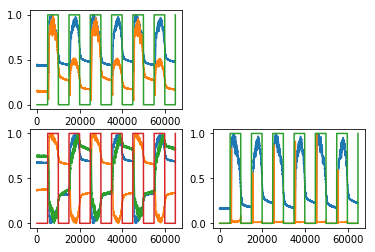

In [13]:
i = -1
print prefeat[i].shape#, newprefeat[i].shape
plt.subplot(2,2,1)
plt.plot(prefeat[i]/np.max(prefeat[i],axis=0))
# plt.subplot(2,2,2)
# plt.plot(newprefeat[i]/np.max(newprefeat[i],axis=0))
plt.subplot(2,2,3)
plt.plot((f[i]-np.min(f[i],axis=0))/(np.max(f[i],axis=0)-np.min(f[i],axis=0)))
plt.subplot(2,2,4)
plt.plot((newprefeat2[i]-np.min(newprefeat2[i],axis=0))/(np.max(newprefeat2[i],axis=0)-np.min(newprefeat2[i],axis=0)))

In [13]:
# plt.figure(figsize=(50,80))
# for i in range(prefeat.shape[0]):
#     plt.subplot(10,5,i+1)
#     plt.plot(prefeat[i]/np.max(prefeat[i],axis=0))

In [13]:
# plt.figure()
# plt.subplot(2,1,1)
# plt.plot(prefeat[-2]/np.max(prefeat[-2],axis=0))
# plt.hold
# plt.plot(newprefeat[-2]/np.max(newprefeat[-2],axis=0))
# plt.subplot(2,1,2)
# plt.plot(newprefeat2[-2]/np.max(newprefeat2[-2],axis=0))
prefeat = newprefeat2
print prefeat.shape,":",[p.shape for p in prefeat]

 (72,) : [(344902, 3), (104901, 3), (209901, 3), (224902, 3), (129901, 3), (64901, 3), (194901, 3), (64901, 3), (129901, 3), (194901, 3), (64901, 3), (129901, 3), (224902, 3), (64901, 3), (129901, 3), (194901, 3), (64901, 3), (129901, 3), (74901, 3), (129901, 3), (194901, 3), (194901, 3), (129901, 3), (64901, 3), (64901, 3), (129901, 3), (194901, 3), (194901, 3), (129901, 3), (64901, 3), (64901, 3), (129901, 3), (194901, 3), (129901, 3), (194901, 3), (64901, 3), (344902, 3), (104901, 3), (209901, 3), (224902, 3), (129901, 3), (64901, 3), (194901, 3), (64901, 3), (129901, 3), (194901, 3), (64901, 3), (129901, 3), (224902, 3), (64901, 3), (129901, 3), (194901, 3), (64901, 3), (129901, 3), (74901, 3), (129901, 3), (194901, 3), (194901, 3), (129901, 3), (64901, 3), (64901, 3), (129901, 3), (194901, 3), (194901, 3), (129901, 3), (64901, 3), (64901, 3), (129901, 3), (194901, 3), (129901, 3), (194901, 3), (64901, 3)]


In [15]:
############################# Computation time of ALL features in secs #############################################
t1 = time.time()
tmpfeat = [feat(prefeat[15][i:i+window,:2],*featparam) for i in range(100)] # avg over 100 times
print (time.time()-t1)/100

0.0015589094162


/home/jagrio/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0 (344902,) (344902, 3)
1 (104901,) (104901, 3)
2 (209901,) (209901, 3)
3 (224902,) (224902, 3)
4 (129901,) (129901, 3)
5 (64901,) (64901, 3)
6 (194901,) (194901, 3)
7 (64901,) (64901, 3)
8 (129901,) (129901, 3)
9 (194901,) (194901, 3)
10 (64901,) (64901, 3)
11 (129901,) (129901, 3)
12 (224902,) (224902, 3)
13 (64901,) (64901, 3)
14 (129901,) (129901, 3)
15 (194901,) (194901, 3)
16 (64901,) (64901, 3)
17 (129901,) (129901, 3)
18 (74901,) (74901, 3)
19 (129901,) (129901, 3)
20 (194901,) (194901, 3)
21 (194901,) (194901, 3)
22 (129901,) (129901, 3)
23 (64901,) (64901, 3)
24 (64901,) (64901, 3)
25 (129901,) (129901, 3)
26 (194901,) (194901, 3)
27 (194901,) (194901, 3)
28 (129901,) (129901, 3)
29 (64901,) (64901, 3)
30 (64901,) (64901, 3)
31 (129901,) (129901, 3)
32 (194901,) (194901, 3)
33 (129901,) (129901, 3)
34 (194901,) (194901, 3)
35 (64901,) (64901, 3)
36 (344902,) (344902, 3)
37 (104901,) (104901, 3)
38 (209901,) (209901, 3)
39 (224902,) (224902, 3)
40 (129901,) (129901, 3)
41 (649

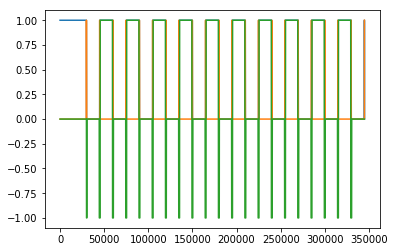

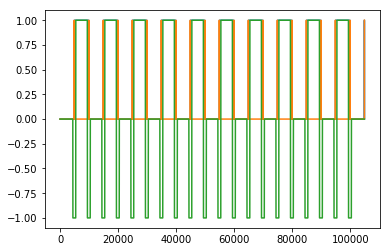

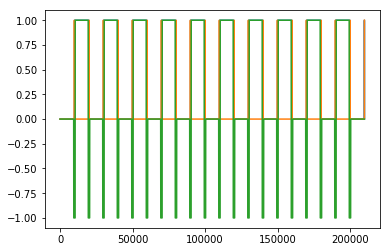

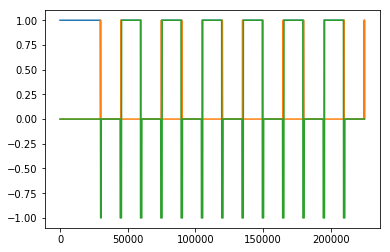

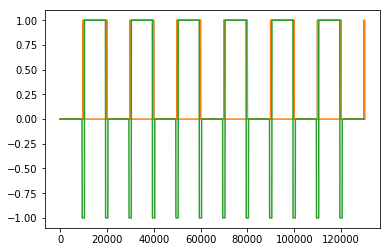

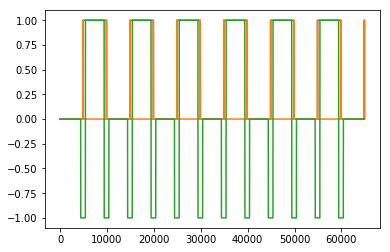

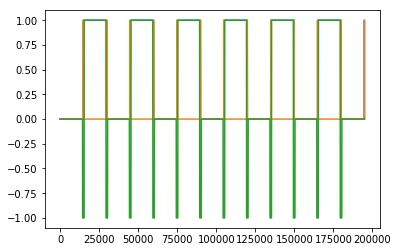

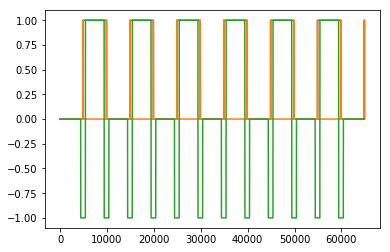

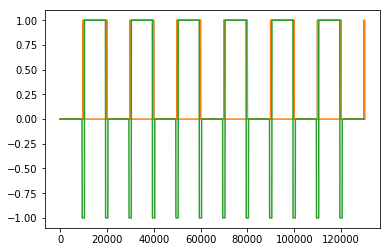

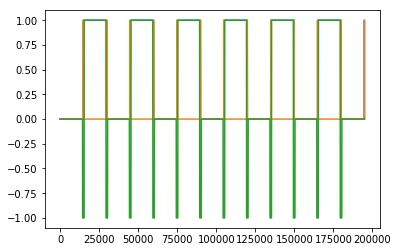

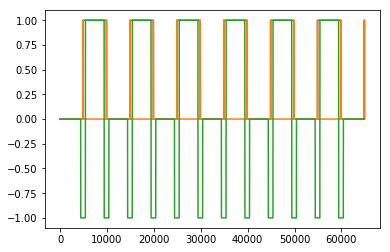

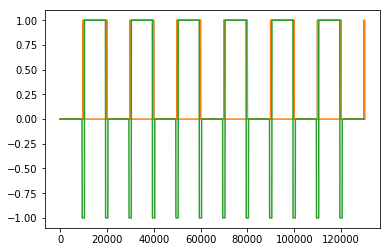

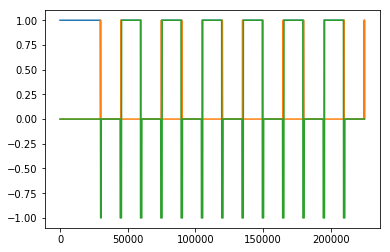

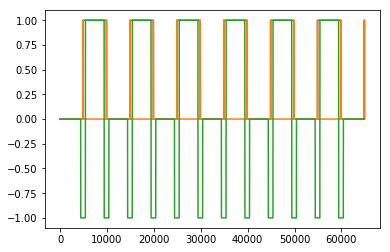

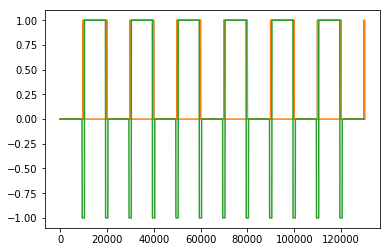

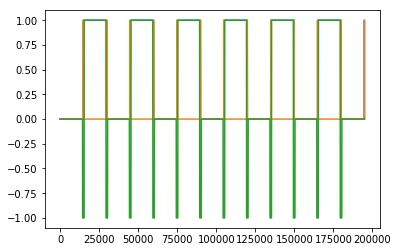

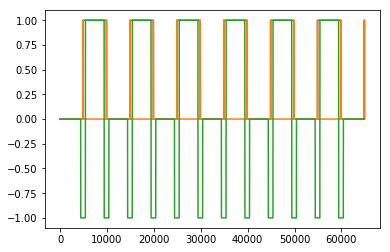

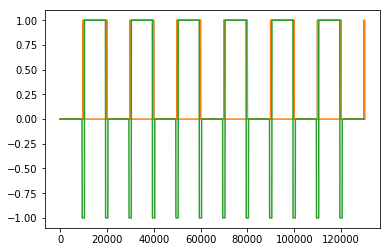

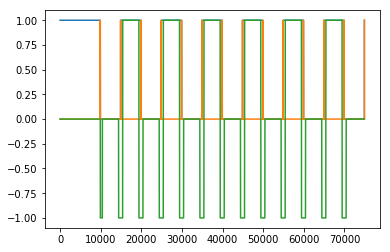

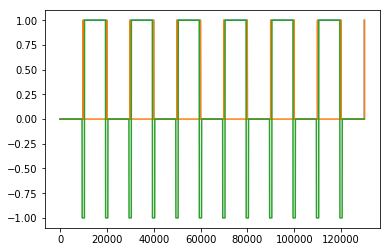

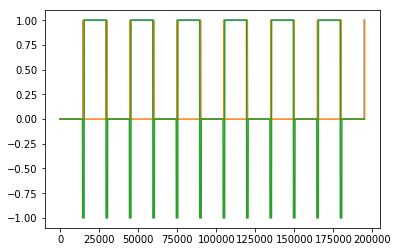

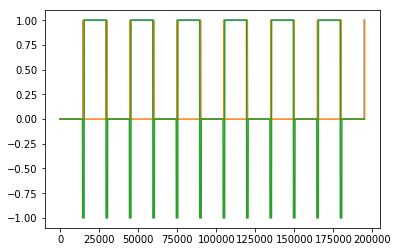

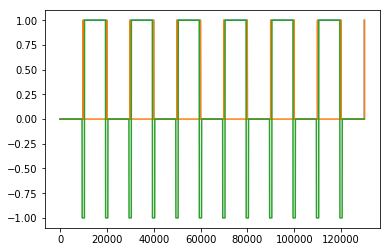

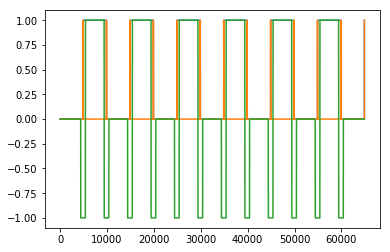

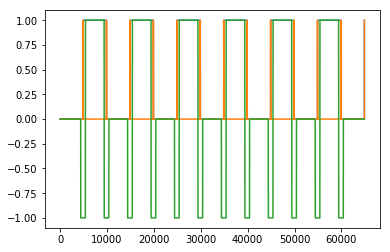

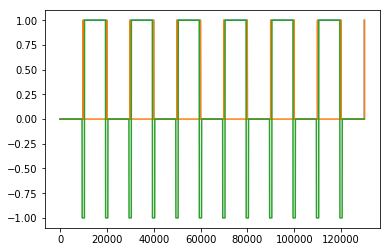

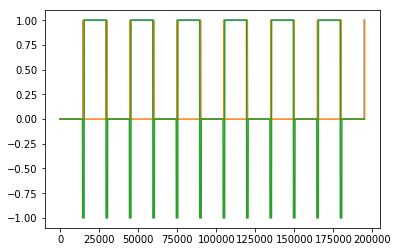

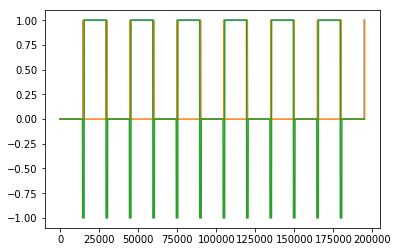

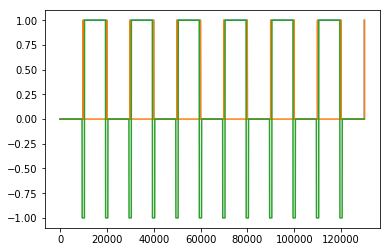

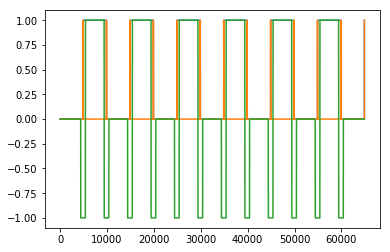

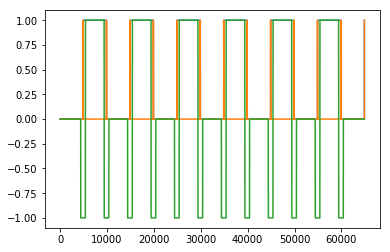

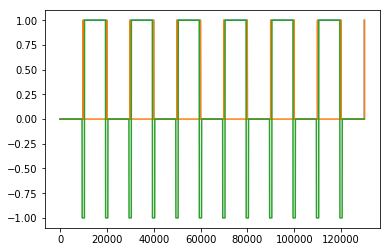

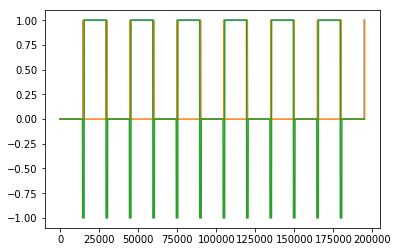

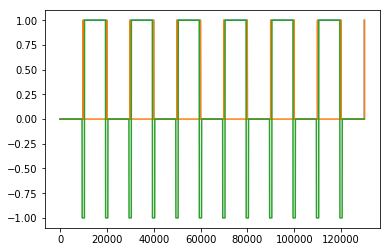

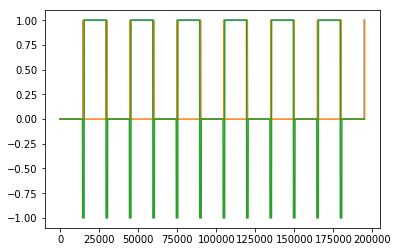

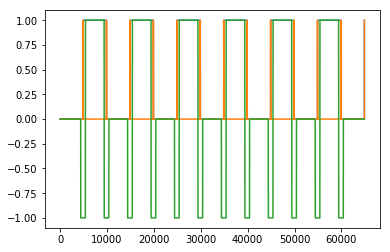

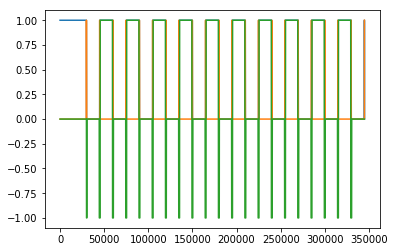

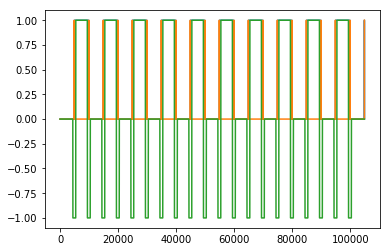

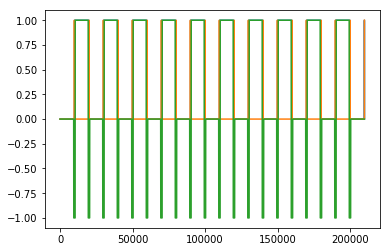

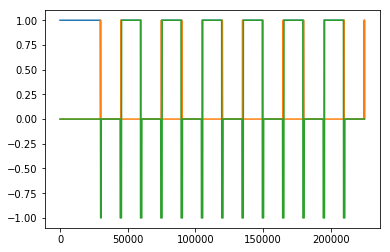

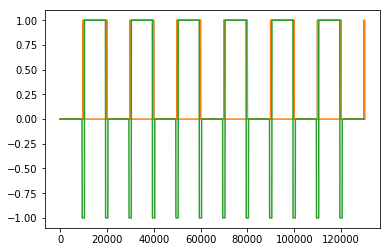

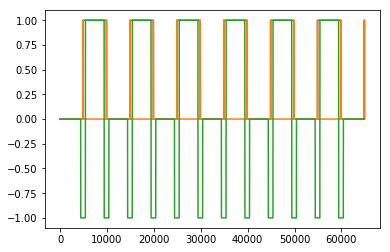

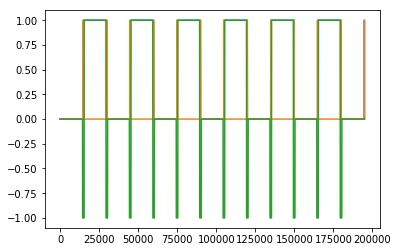

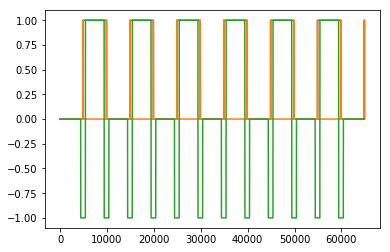

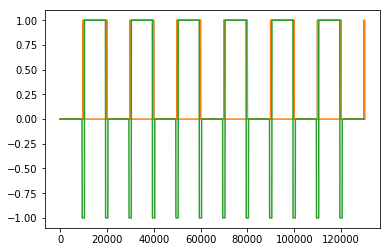

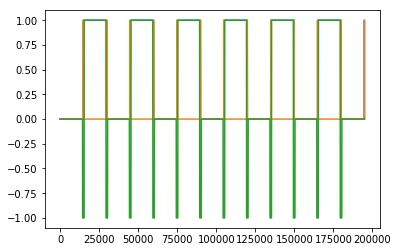

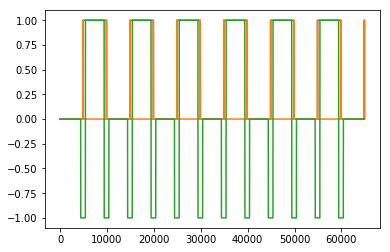

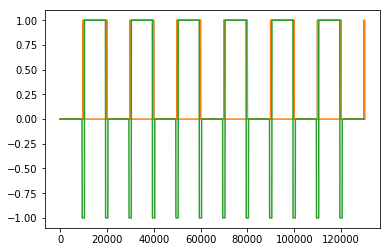

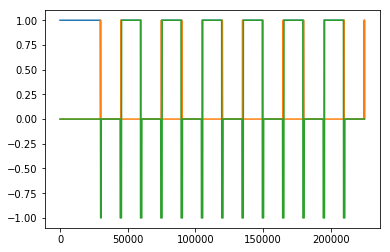

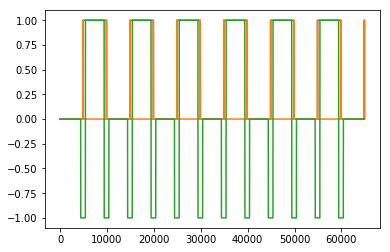

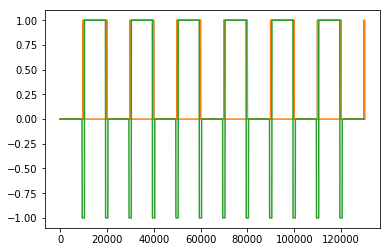

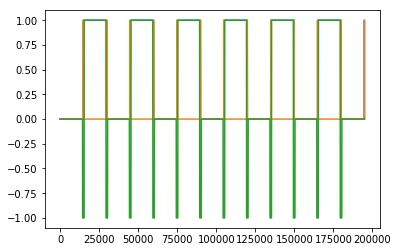

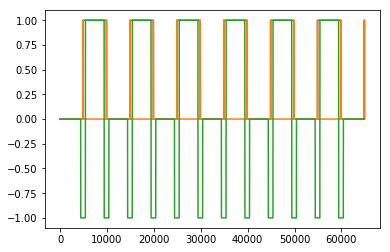

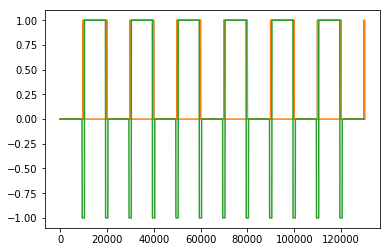

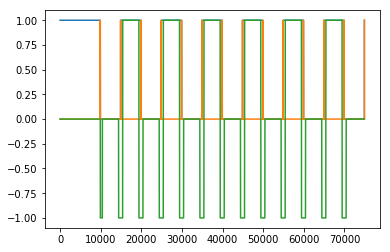

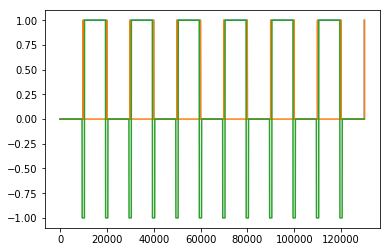

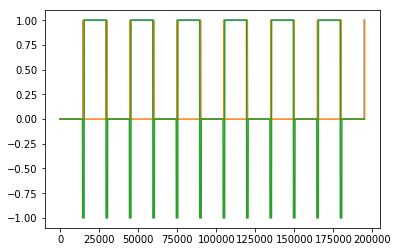

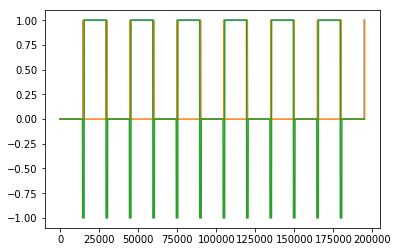

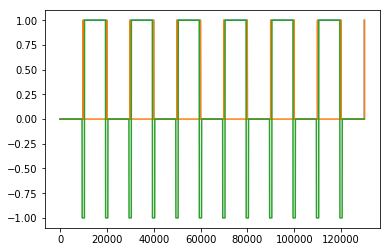

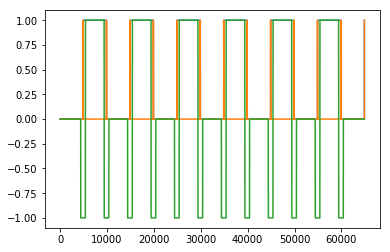

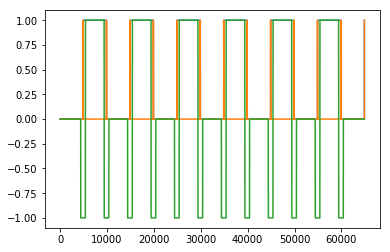

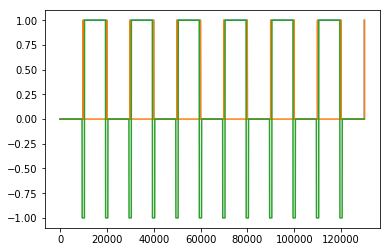

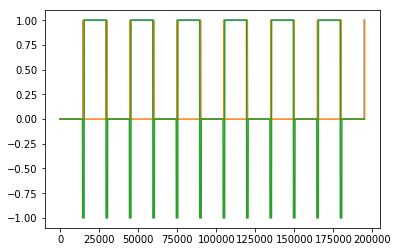

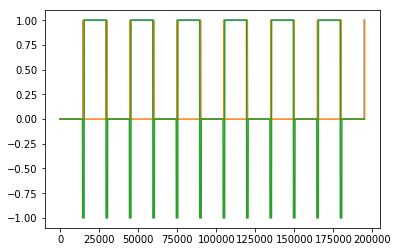

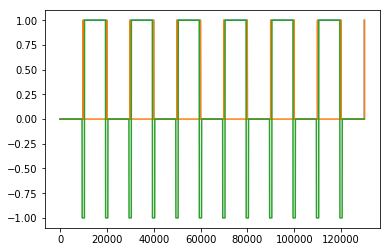

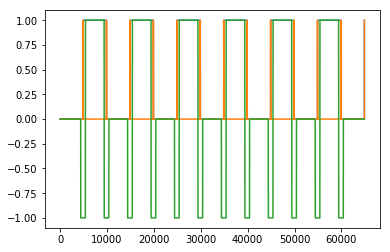

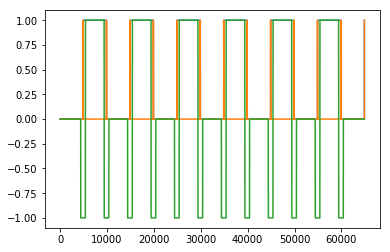

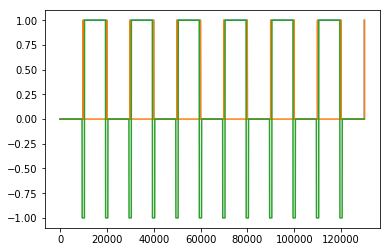

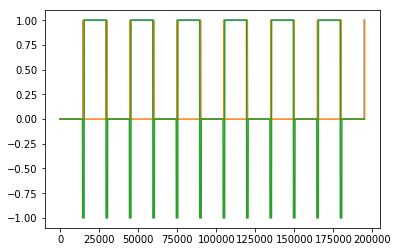

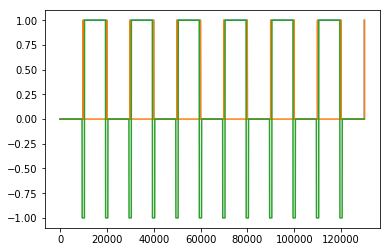

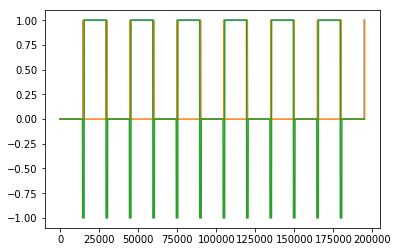

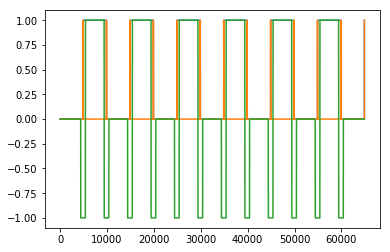

In [14]:
# ####======= Code for keeping as much as possible only the pure stable and slip parts of label 
lbl_approx = []
history = 500
for i in range(len(prefeat)):
    tmpd = np.abs(np.diff(prefeat[i][:,-1].astype(int),n=1,axis=0))
    if np.sum(tmpd) > 0:
        # find the sign change points
        tmpind = np.array(range(len(tmpd)))[tmpd > 0]
#         print i, prefeat[i].shape, np.sum(tmpd), tmpind
        tmpindrng = []
        for j in range(len(tmpind)):
            # keep/throw a portion of the signal's length around change points
            length = history
            tmprng = np.array(range(tmpind[j]-length,tmpind[j]+length))
            # make sure inside singal's x-range
            tmprng = tmprng[tmprng>=0]
            tmprng = tmprng[tmprng<prefeat[i].shape[0]]
            tmpindrng += tmprng.tolist()
#             print len(tmpindrng)
        tmpindrng = np.array(tmpindrng).flatten()
#         print tmpindrng
        tmp_lbl = deepcopy(prefeat[i][:,-1])
        tmp_lbl[tmpindrng] = -1
        # fix labels that start with slipping and make them stable
        if tmp_lbl[0]==1:
            tmp_lbl[:tmpind[0]+1] = 0
        tmp_lbl[-2*history-2:] *= 0
        lbl_approx.append(tmp_lbl)
        plt.figure()
        plt.plot(prefeat[i][:,-1])
        plt.hold
        plt.plot(tmpd)
        plt.plot(lbl_approx[-1][:])
    else:
        lbl_approx.append(prefeat[i][:,-1])
for i in range(len(lbl_approx)):
    print i, lbl_approx[i].shape, prefeat[i].shape

In [15]:
############################################# FEATURE COMPUTATION ##################################################
# featname = 'newfeatures'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
# featname = 'newfeatures_trans'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
# featfile = featpath+featname+'.npz'
# XYfile = featpath+featname+'_XY.npz'
# XYnormfile = featpath+featname+'_XYnorm.npz'
# def tmpfeatfilename(p,mode='all'):
#     if mode == 'all':
#         return featpath+'allfeats/'+'feat'+str(p)+'.pkl.z'
#     elif mode == 'red':
#         return featpath+'allfeats/'+'feat'+str(p)+'red'+str(samplesperdataset)+'.pkl.z'
def tmpfeatfilename(p,mode='all'):
    if mode == 'all':
        return featpath+'allfeats/'+'feat_newdata1and2_NOsample_transtart'+str(p)+'.pkl.z'
    elif mode == 'red':
        return featpath+'allfeats/'+'feat_newdata1and2_NOsample_transtart'+str(p)+'red'+str(samplesperdataset)+'.pkl.z'
if os.path.isfile(XYfile):
    print "Continuing to XY values..."
else:
    if os.path.isfile(featfile):
        start_time = time.time()
        features = np.load(featfile)['features']
        labels = np.load(featfile)['labels']
        print("Features FOUND PRECOMPUTED! Feature Loading DONE in: %s seconds " % (time.time() - start_time))
    else:
        start_time = time.time()
        features = []
        labels = []
        for ixp in range(len(prefeat)):
            p = prefeat[ixp]
            now = time.time()
            tmpfn = tmpfeatfilename(ixp)
            tmpfnred = tmpfeatfilename(ixp,'red')
            if not os.path.isfile(tmpfnred):
                if not os.path.isfile(tmpfn):
                    # Computation of all features in parallel by all cores
                    tmp = np.array([Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])])
                    with open(tmpfn,'wb') as fo:
                        joblib.dump(tmp,fo)
                    print ixp, time.time()-now, tmpfn, tmp.shape
                else:
                    with open(tmpfn,'rb') as fo:
                        tmp = joblib.load(fo)
                    print ixp, time.time()-now, tmpfn, ' already here!', tmp.shape
                # keep less from each feature vector but keep number of samples for each dataset almost equal
                #tmpskip = int(round(tmp.shape[1]/200.))
                tmpskip = int(round(tmp.shape[1]/(member[ixp]*samplesperdataset)))
                if tmpskip == 0: 
                    tmpskip = 1
#                 print tmp.shape, member[ixp], tmpskip
                # Save reduced size features
                print tmp.shape
                tmp = tmp[0,::tmpskip,:,:]
                with open(tmpfnred,'wb') as fo:
                    joblib.dump(tmp,fo)
                print ixp, time.time()-now, tmpfnred, tmp.shape
        for ixp in range(len(prefeat)):  
            tmpfnred = tmpfeatfilename(ixp,'red')
            with open(tmpfnred,'rb') as fo:
                tmp = joblib.load(fo)
            print ixp, time.time()-now, tmpfnred, 'already here!', tmp.shape
            features.append(tmp[:,:,:2])
            labels.append(tmp[:,0,2])
            #features.append(tmp[0,::tmpskip,:,:2])
            #labels.append(tmp[0,::tmpskip,0,2])
            #print np.array(features.shape), np.array(labels.shape)
            #print 'features: ',np.array(features).shape,[f.shape for f in features]
            #print 'labels: ', np.array(labels).shape,[l.shape for l in labels]
        #allfeatures = [Parallel(n_jobs=4)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)]) for p in prefeat[:-7]]
        #allfeatures = [[feat(p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)] for p in prefeat[:-7]]
        #allfeatures = [[feat(p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)] for p in prefeat[-7:]]
        #print 'allfeatures: ',allfeatures.shape
        print("Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: %s seconds " % (time.time() - start_time))
        #raw_input()
        #features = np.array([np.array(fi)[:,:,:-1] for fi in allfeatures])
        #labels = np.array([np.array(fi)[:,0,-1] for fi in allfeatures])
        features = np.array(features)
        # ommit the last computed feature ffaf, which consumes most of computation time
#         features = np.array([ftmp[:,:-1,:] for ftmp in features])
        labels = np.array(labels)
        print 'features: ',features.shape,[ftmp.shape for ftmp in features]
        print 'labels: ', labels.shape,[l.shape for l in labels]
        #print("Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: %s seconds " % (time.time() - start_time))
        np.savez(featfile,features=features,labels=labels)
        #sio.savemat(featpath+featname+'.mat',mdict={'features': features,'labels': labels})
    print features.shape, labels.shape
    for i in range(features.shape[0]):
        print i, np.array(features[i]).shape, np.array(labels[i]).shape

Continuing to XY values...


In [18]:
if os.path.isfile(featfile):
    start_time = time.time()
    features = np.load(featfile)['features']
    labels = np.load(featfile)['labels']
    print("Features FOUND PRECOMPUTED! Feature Loading DONE in: %s seconds " % (time.time() - start_time))
else:
    print("Features NOT FOUND BUT SHOULD BE precomputed! DO something about it!")
print features.shape, labels.shape
for i in range(features.shape[0]):
    print i, np.array(features[i]).shape, np.array(labels[i]).shape

Features FOUND PRECOMPUTED! Feature Loading DONE in: 10.7393648624 seconds 
(36,) (36,)
0 (529, 3107, 2) (529,)
1 (538, 3107, 2) (538,)
2 (571, 3107, 2) (571,)
3 (571, 3107, 2) (571,)
4 (538, 3107, 2) (538,)
5 (534, 3107, 2) (534,)
6 (534, 3107, 2) (534,)
7 (538, 3107, 2) (538,)
8 (571, 3107, 2) (571,)
9 (571, 3107, 2) (571,)
10 (538, 3107, 2) (538,)
11 (534, 3107, 2) (534,)
12 (534, 3107, 2) (534,)
13 (538, 3107, 2) (538,)
14 (571, 3107, 2) (571,)
15 (538, 3107, 2) (538,)
16 (571, 3107, 2) (571,)
17 (534, 3107, 2) (534,)
18 (529, 3107, 2) (529,)
19 (538, 3107, 2) (538,)
20 (571, 3107, 2) (571,)
21 (571, 3107, 2) (571,)
22 (538, 3107, 2) (538,)
23 (534, 3107, 2) (534,)
24 (534, 3107, 2) (534,)
25 (538, 3107, 2) (538,)
26 (571, 3107, 2) (571,)
27 (571, 3107, 2) (571,)
28 (538, 3107, 2) (538,)
29 (534, 3107, 2) (534,)
30 (534, 3107, 2) (534,)
31 (538, 3107, 2) (538,)
32 (571, 3107, 2) (571,)
33 (538, 3107, 2) (538,)
34 (571, 3107, 2) (571,)
35 (534, 3107, 2) (534,)


In [16]:
# ======= Code for keeping as much as possible only the pure stable and slip parts of label after feature extraction 
new_labels = deepcopy(labels)
for ixp in range(len(lbl_approx)):
    p = lbl_approx[ixp]
    tmp = np.array([p[k+window] for k in range(0,len(p)-window,shift)])
#     print ixp, tmp.shape
    tmpskip = int(round(tmp.shape[0]/(member[ixp]*samplesperdataset)))
    if tmpskip == 0: 
        tmpskip = 1
    #                 print tmp.shape, member[ixp], tmpskip
    # Save reduced size features
    tmp = tmp[::tmpskip]
    if len(tmp) > len(labels[ixp]):
        tmp = tmp[:-1]
    new_labels[ixp] = tmp
    print ixp, tmp.shape, labels[ixp].shape
print new_labels.shape

NameError: name 'labels' is not defined

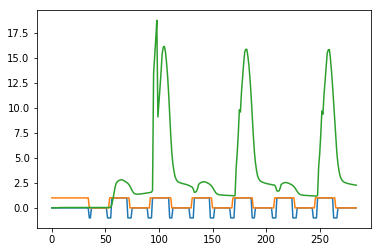

In [22]:
plt.plot(new_labels[18])
plt.hold
plt.plot(labels[18])
plt.hold
plt.plot(features[18][:,1,1])

In [21]:
# nfeatures = deepcopy(features)
# new labels are the original without the transition phases!!!!
#######labels = new_labels
# for i in range(features.shape[0]):
# #     print i, np.array(nfeatures[i]).shape, np.array(labels[i]).shape
#     features[i] = np.concatenate((features[i][:,:,0],features[i][:,:,1]),axis=1)
#     print i, np.array(features[i]).shape, np.array(labels[i]).shape

In [24]:
m1,m2

(36, 36)

In [17]:
### GATHER ALL FEATURES TOGETHER and NORMALIZE THEM ######################################
############# GATHERING features and labels into one array each
if os.path.isfile(XYfile):
    print "Continuing to XY values..."
else:
    #features = features[:,::keepfromshift,:]
    #labels = labels[:,::keepfromshift,:]
    ind,feats = {},{}
    l_ind = [0,0,0]
    ind[2] = range(features.shape[0])                                      # indeces for all datasets
#     print features.shape, len(ind[2]), int(round(len(ind[2])*1./samplesperdataset))
#     ind[2] = ind[2][::int(round(len(ind[2])*1./samplesperdataset))]
    ind[0] = range(features.shape[0])[:m1]                                 # indeces for pillbox dataset12
#     ind[0] = ind[0][::int(round(len(ind[0])*1./samplesperdataset))]
    ind[1] = range(features.shape[0])[-m2:]                          # indeces or different surfaces dataset3
#     ind[1] = ind[1][::int(round(len(ind[1])*1./samplesperdataset))]
    ind = np.array([i for _,i in ind.items()])
    feats[0] = features[ind[0]]                                              # features for pillbox
    feats[1] = features[ind[1]]
    feats[2] = features[ind[2]]                                            # features for differ. surfaces
    print 'prefeats: ',feats[0].shape, feats[1].shape, feats[2].shape
#     feats[2] = np.concatenate(features,axis=0)                                # all features together
    feats[2] = np.concatenate(feats[2],axis=0)
    print feats[2].shape#,int(round(feats[2].shape[0]*1./samplesperdataset))
    l_ind[2] = feats[2].shape[0]
    feats[2] = np.array([feats[2][:,:,i] for i in range(feats[2].shape[2])])
    feats[2] = feats[2][:,::int(round(feats[2].shape[1]*1./samplesperdataset)),:]
    print feats[2].shape
    feats[0] = np.concatenate(feats[0],axis=0)
    print feats[0].shape#,int(round(feats[0].shape[0]*1./samplesperdataset))
    l_ind[0] = feats[0].shape[0]
    feats[0] = np.array([feats[0][:,:,i] for i in range(feats[0].shape[2])])
    feats[0] = feats[0][:,::int(round(feats[0].shape[1]*1./samplesperdataset)),:]
    print feats[0].shape
    feats[1] = np.concatenate(feats[1],axis=0)
    print feats[1].shape#,int(round(feats[1].shape[0]*1./samplesperdataset))
    l_ind[1] = feats[1].shape[0]
    feats[1] = np.array([feats[1][:,:,i] for i in range(feats[1].shape[2])])
    feats[1] = feats[1][:,::int(round(feats[1].shape[1]*1./samplesperdataset)),:]
    print feats[1].shape
    feats = [i for _,i in feats.items()]
    print 'feats: ',feats[0].shape, feats[1].shape, feats[2].shape
#     labs = np.concatenate(labels[ind[0]+ind[1]+ind[2]],axis=0)
    labs = np.concatenate(labels[ind[2]],axis=0)
    print 'labs: ',labs.shape
#     labsn = np.concatenate(new_labels[ind[0]+ind[1]+ind[2]],axis=0)
    labsn = np.concatenate(new_labels[ind[2]],axis=0)
    print 'labsnew: ',labsn.shape

Continuing to XY values...


In [18]:
############# GATHERING into one complete array
if os.path.isfile(XYfile):
    X = np.load(XYfile)['X']
    Y = np.load(XYfile)['Y']
    Yn = np.load(XYfile)['Yn']
else:
    X,Y,Yn = {},{},{}
#     ind[2] = np.array(range(feats[0].shape[1]+feats[1].shape[1],feats[0].shape[1]+feats[1].shape[1]+feats[2].shape[1]))
#     ind[2] = np.array(range(feats[2].shape[1]))
    ind[2] = np.array(range(l_ind[2]))
    ind[2] = ind[2][::int(round(len(ind[2])*1./samplesperdataset))]
    ind[0] = np.array(range(l_ind[0]))                               # indeces for pillbox dataset12
    ind[0] = ind[0][::int(round(len(ind[0])*1./samplesperdataset))]
    ind[1] = np.array(range(l_ind[0],l_ind[0]+l_ind[1]))
    ind[1] = ind[1][::int(round(len(ind[1])*1./samplesperdataset))]
    print ind[0].shape, ind[1].shape, ind[2].shape, feats[0].shape, feats[1].shape, feats[2].shape
#     raw_input()
    X[2],Y[2],Yn[2] = np.concatenate([feats[2][i] for i in range(feats[2].shape[0])],axis=1),labs[ind[2]],labsn[ind[2]]
    print X[2].shape, Y[2].shape, Yn[2].shape 
    X[0],Y[0],Yn[0] = np.concatenate([feats[0][i] for i in range(feats[0].shape[0])],axis=1),labs[ind[0]],labsn[ind[0]]
    print X[0].shape, Y[0].shape, Yn[0].shape 
    X[1],Y[1],Yn[1] = np.concatenate([feats[1][i] for i in range(feats[1].shape[0])],axis=1),labs[ind[1]],labsn[ind[1]]
    print X[1].shape, Y[1].shape, Yn[1].shape 
    X = np.array([i for _,i in X.items()])
    Y = np.array([i for _,i in Y.items()])
    Yn = np.array([i for _,i in Yn.items()])
    np.savez(XYfile,X=X,Y=Y,Yn=Yn)
print 'gathered features: ', X[0].shape, Y[0].shape, Yn[0].shape, X[1].shape, Y[1].shape, Y[1].shape, X[2].shape, Y[2].shape, Y[2].shape, np.sum(Y[2]),  np.sum(Yn[2])

gathered features:  (10166, 6214) (10166,) (10166,) (10166, 6214) (10166,) (10166,) (10166, 6214) (10166,) (10166,) 4814.0 2938.0


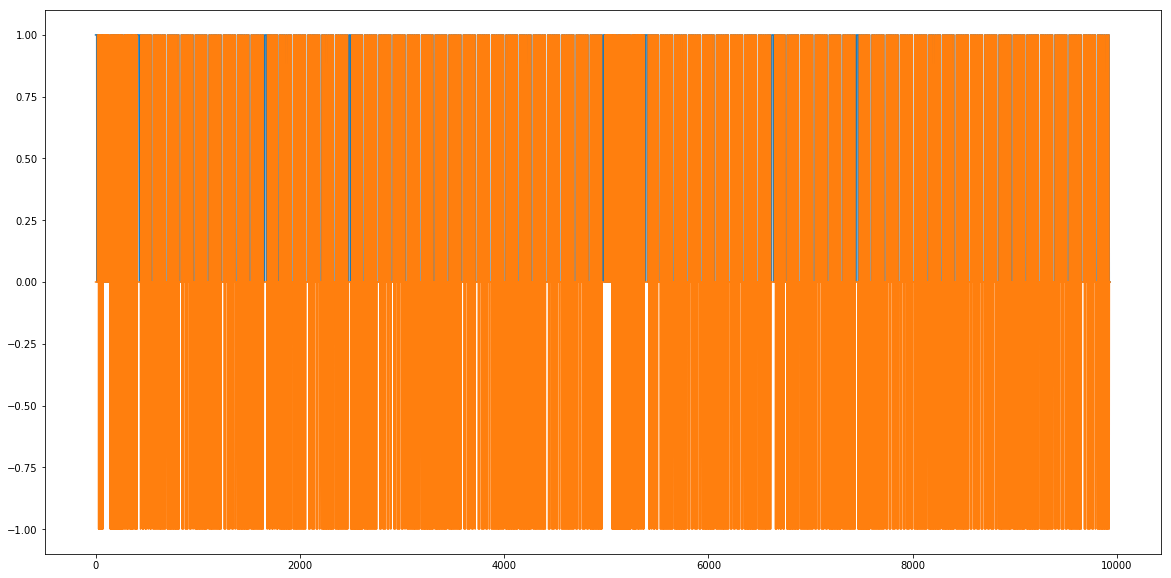

In [22]:
plt.figure(figsize=(20,10))
plt.plot(Y[2])
plt.hold
plt.plot(Yn[2])

In [26]:
# X = np.load(featpath+'newfeatures_newdata_NOsample_1024_20_10_10000_XY.npz')['X']
# Y = np.load(featpath+'newfeatures_newdata_NOsample_1024_20_10_10000_XY.npz')['Y']
# print 'gathered features: ', X[0].shape, Y[0].shape, X[1].shape, Y[1].shape, X[2].shape, Y[2].shape, np.sum(Y[2])

In [19]:
# ############################ XY file for split feature sets and filtered label ###################################
XYsplitfile = featpath+featname+'_XYsplit.npz'
tmpind = {}
tmpind[2] = range(X[0].shape[1])
tmpind[0] = range(X[0].shape[1]/2)
tmpind[1] = range(X[0].shape[1]/2,X[0].shape[1])
tmpind = np.array([i for _,i in tmpind.items()])
keepind = np.zeros((X.shape[0])).tolist()
if os.path.isfile(XYsplitfile):
    Xsp = np.load(XYsplitfile)['Xsp']
    Ysp = np.load(XYsplitfile)['Ysp']
else:
#     Xsp,Ysp = {},{}
#     Xsp = np.zeros((X.shape[0],len(tmpind))).tolist()
#     Ysp = np.zeros((X.shape[0])).tolist()
    Xsp, Ysp = [], []
    for i in range(X.shape[0]):
        # find labels with -1 (keep above 0) and ignore them from both Y and X
        keepind[i] = Yn[i]>=0
#         Ysp[i] = deepcopy(Yn[i][keepind[i]])
#         Ysp[i] = Yn[i][keepind[i]]
        Ysp.append(Yn[i][keepind[i]])
#         Xsp[i] = {}
        Xsp.append([])
        for j in range(len(tmpind)):
#             Xsp[i][j] = deepcopy(X[i][:,tmpind[j]])
#             Xsp[i][j] = Xsp[i][j][keepind[i],:]
#             print keepind[i].shape, X[i].shape, len(tmpind[j])
#             Xsp[i][j] = X[i][:,tmpind[j]][keepind[i],:]
            Xsp[i].append(X[i][:,tmpind[j]][keepind[i],:])
            print i, j, Xsp[i][j].shape, Ysp[i].shape
#     print len(Xsp[0][0]), Xsp, np.asarray(Xsp)
#     Xsp = np.array([np.array(Xsp[i]) for i in range(len(Xsp))])
#     Xsp = np.asarray(Xsp,dtype=object)
#     Xsp = np.array([[xsij for _,xsij in Xsp[i].items()] for i in range(len(Xsp))])
    tmp = len(keepind[0])
    for i in range(len(keepind)):
        if len(keepind[i]) == tmp:
            if i < len(keepind)-1:
                continue
            else:
                Ysp[i] = Ysp[i][1:]
                for j in range(len(tmpind)):
                    Xsp[i][j] = Xsp[i][j][1:,:]
                    print i, j, Xsp[i][j].shape, Ysp[i].shape
                break
        else:
            break
    Xsp = np.array(Xsp)
    Ysp = np.array(Ysp)
#     Xsp = np.array([[Xij for _,Xij in Xi.items()] for _,Xi in Xsp.items()])
#     Ysp = np.array([i for _,i in Ysp.items()])
    np.savez(XYsplitfile,Xsp=Xsp,Ysp=Ysp)
print Xsp.shape, Ysp.shape

0 0 (9003, 3107) (9003,)
0 1 (9003, 3107) (9003,)
0 2 (9003, 6214) (9003,)
1 0 (9003, 3107) (9003,)
1 1 (9003, 3107) (9003,)
1 2 (9003, 6214) (9003,)
2 0 (9002, 3107) (9002,)
2 1 (9002, 3107) (9002,)
2 2 (9002, 6214) (9002,)
2 0 (9001, 3107) (9001,)
2 1 (9001, 3107) (9001,)
2 2 (9001, 6214) (9001,)
(3, 3) (3,)


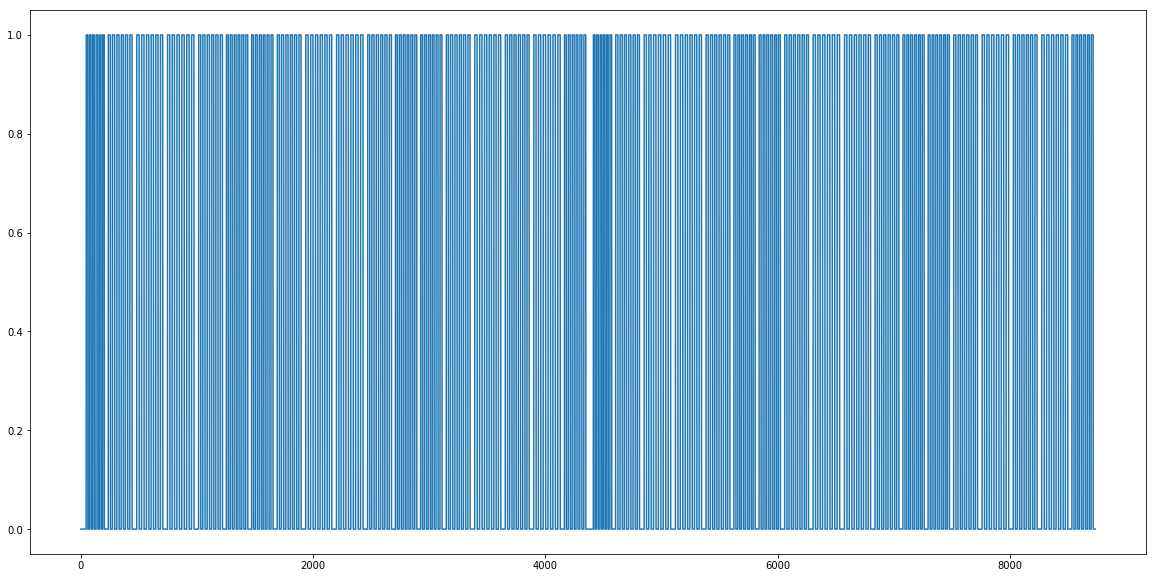

In [30]:
plt.figure(figsize=(20,10))
plt.plot(Ysp[2])

In [23]:
# %%time
# state = 42
# skipdata = 20
# best_parameters = np.zeros((X.shape[0],len(tmpind),len(classifiers))).tolist()
# best_clf = np.zeros((X.shape[0],len(tmpind),len(classifiers))).tolist()
# best_fs_sc = np.zeros((X.shape[0],len(tmpind),len(classifiers))).tolist()
# for i in range(X.shape[0]):
#     y_tot = np.copy(Ysp[i]) ; y_tot = y_tot[::skipdata]
#     for j in range(len(tmpind)):
#         x_tot = np.copy(Xsp[i][j]) ; x_tot = x_tot[::skipdata,:]
        
#         # Grid search for param tuning for all classifiers
# #         cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = state)
#         cv = KFold(n_splits = 5, shuffle = False, random_state = state)
#         for clfid, clfval in enumerate(classifiers[:-1]):
#             print i, j, x_tot.shape, y_tot.shape, clfid, clfval
#             grid_pip = make_pipe_clf(StandardScaler(),SelectKBest(),PCA(),clfval)
#             p1 = makepipe_parameters_clf[clfid]
#             p2 = makepipe_parameters_clf[-2]
#             p3 = makepipe_parameters_clf[-1]
#             params = reduce(lambda x,y: dict(x, **y), (p1, p2, p3))
# #             print p1,p2,p3,params
#             grid_search = GridSearchCV(grid_pip, params, verbose = 1, cv = cv, n_jobs=-1)
# #             if clfid != len(classifiers):
#             grid_search.fit(x_tot, y_tot)
# #             print best_parameters[i][j][clfid]
#             best_parameters[i][j][clfid] = grid_search.best_estimator_.get_params()
#             print("------ Grid search cv results for "+names[clfid]+" ------")
#             print("Best score: %0.4f" %grid_search.best_score_)
#             print("Best parameters set:")
# #             best_parameters += [grid_search.best_estimator_.get_params()]
#             for param_name in sorted(params.keys()):
#                  print("\t%s: %r" % (param_name, best_parameters[i][j][clfid][param_name]))
#             best_clf[i][j][clfid] = grid_pip.set_params(**best_parameters[i][j][clfid])
# #             raw_input()
# #             best_fit = best_clf[i][j][clfid].fit(x_tot,y_tot)
#             best_fs = best_clf[i][j][clfid].named_steps['feature_selection']
#             pipe_fs_unsorted = best_fs.scores_
#             best_fs_sc[i][j][clfid] = pipe_fs_unsorted
# #             fs_inds = pipe_fs_unsorted.argsort()
# #             pipe_fs = pipe_fs_unsorted[fs_inds]
# #########
# #             #print the top features selected
# #             best_fs = gridpip.set_params(**self.classifiers[self.actual_ind]).named_steps['feature_selection']
# # #           self.best_fs = self.pipe.set_params(**self.classifiers[self.actual_ind]).named_steps['feature_selection']
# # #           best_fs = pipeline[actual_ind].named_steps['feature_selection']
# # #             self.best_fs_indd = self.best_fs.get_support(indices = True)
# # #                 print(self.best_fs_indd)
# #             pipe_fs_unsorted = best_fs.scores_
# # #             self.fs_inds = self.pipe_fs_unsorted.argsort()
# # #                 print(self.fs_inds)
# #             self.pipe_fs = self.pipe_fs_unsorted[self.fs_inds]
# #             self.temp3 = 0 # temp3 = 0:number of features

# #             for self.temp_ind2 in range(-1, -(self.nfeat +1), -1):         
# #                 self.best_feat_ind[self.temp2][self.temp3]=self.fs_inds[self.temp_ind2]
# #                 self.total_feats[self.fs_inds[self.temp_ind2]]+=1 # feature scores 
# #                 self.temp3+=1
# # #                 print(self.total_feats)
# #             #fit the best classifier on the outer test data
# #             self.best_pip = self.pipe.set_params(**self.classifiers[self.actual_ind])

# #             self.best_pip.fit(self.x_trn_out, self.y_trn_out)

# #             #get the outer score 
# #             self.outer_scores[self.temp2, self.fold_out] = self.best_pip.score(self.x_tst_out, self.y_tst_out)
# #             print("Inner score: %f VS Outer score: %f \n" %(self.inner_mean_scores[self.actual_ind], self.outer_scores[self.temp2, self.fold_out]))
# #             print ("----------------------------------------------------------")
# #             self.temp2+=1
# ###########
            
            
# #             else:
#                 # ensemble MLP
# #                 x_tot_Ens = best_clf[i][j][clfid]
# #                 grid_search.fit(x_tot_Ens, y_tot)


In [31]:
# bestparamname = 'bestparams_trans'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
# bestparamfile = featpath+bestparamname+'.npz'
# if os.path.isfile(bestparamfile):
#     best_parameters = np.load(bestparamfile)['bestparams']
#     best_clf = np.load(bestparamfile)['bestclf']
#     best_fs_sc = np.load(bestparamfile)['bestfsscores']
# else:
#     np.savez(bestparamfile,bestparams=best_parameters,bestclf=best_clf,bestfsscores=best_fs_sc)

In [24]:
# tmpmean = np.zeros((X.shape[0],len(tmpind))).tolist()
# for i in range(X.shape[0]):
#     for j in range(len(tmpind)):
#         tmpmean[i][j] = np.zeros(best_fs_sc[i][j][0].shape)
#         for k in range(best_fs_sc[i][j].shape[0]-1):
# #             print best_fs_sc[i][j][k].shape
#             tmpmean[i][j] += best_fs_sc[i][j][k]
# #             print tmpmean[i][j].shape
#         tmpmean[i][j] /= best_fs_sc[i][j].shape[0]
#         plt.figure()
#         plt.plot(tmpmean[i][j])
# #         print tmpmean[i][j]

In [25]:
# for clfid, clfval in enumerate(classifiers[:-1]):
#     grid_pip = make_pipe_clf(StandardScaler(),SelectKBest(),PCA(),clfval)


In [41]:
################################################## NORMALIZATION ###################################################
# normalize by abstracting mean and dividing by std
X = np.array([deepcopy(Xsp[i][-1]) for i in range(Xsp.shape[0])])
Y = deepcopy(Ysp)
print X.shape, Y.shape
tmpind = {}
tmpind[2] = range(X[0].shape[1])
tmpind[0] = range(X[0].shape[1]/2)
tmpind[1] = range(X[0].shape[1]/2,X[0].shape[1])
tmpind = np.array([i for _,i in tmpind.items()])
if os.path.isfile(XYnormfile):
    X = np.load(XYnormfile)['Xs']
    S = np.load(XYnormfile)['S']
    # X = np.load(XYfile)['Xn']
    # N = np.load(XYfile)['N']
else:
    Xn,S,N = {},{},{}
    for i in range(len(X)): # for all datasets
        S[i],N[i] = {},{}
        for j in range(len(tmpind)): # for all features
            S[i][j] = StandardScaler().fit(X[i][:,tmpind[j]])
            #N[i][j] = MinMaxScaler().fit(X[i][:,tmpind[j]])
        X[i] = S[i][len(tmpind)-1].transform(X[i])
        #Xn[i] = N[i][len(tmpind)-1].transform(X[i])
    S = np.array([[Sij for _,Sij in Si.items()] for _,Si in S.items()])
    #N = np.array([[Nij for _,Nij in Ni.items()] for _,Ni in N.items()])
    #Xn = np.array([i for _,i in Xn.items()])
    #np.savez(XYnormfile,Xs=X,Xn=Xn,S=S,N=N)
    np.savez(XYnormfile,Xs=X,S=S)
print 'normalized features: ', X[0].shape, X[1].shape, X[2].shape

(3,) (3,)
normalized features:  (8953, 6214) (8953, 6214) (8948, 6214)


In [26]:
########################################## Feature Names ###########################################################
####################################################################################################################
##  features:                                                                                  ||      if         ##
##  |----------> time domain      :                                                            || samples = 1024  ##
##  |------------|---> phinyomark : 11+3{shist} -----------------------------> = 14+0.0samples ||             14  ##
##  |------------|---> golz       : 10+samples{acrol} -----------------------> = 10+1.0samples ||           1034  ##
##  |----------> frequency domain :                                                                               ##
##  |------------|---> phinyomark : 3{arco}+4{mf}+2(samples/2+1){RF,IF} -----> =  9+1.0samples ||           1033  ##
##  |------------|---> golz       : 2(samples/2+1){AF,PF} ========-----------> =  2+1.0samples ||           1027  ##
##  |------------|--------|-------alltogether--------------------------------> = 35+3.0samples || numfeat = 3108  ##
####################################################################################################################
## Time Domain Phinyomark feats
featnames = ['intsgnl', 'meanabs', 'meanabsslp', 'ssi', 'var', 'rms', 'rng', 'wavl', 'zerox', 'ssc', 'wamp', 
             'shist1', 'shist2', 'shist3']                                                   # 11+3{shist}
## Frequency Domain Phinyomark feats
featnames += ['arco1', 'arco2', 'arco3', 'mnf', 'mdf', 'mmnf', 'mmdf']                       # 3{arco}+4{mf}
featnames += ['reFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{RF}
featnames += ['imFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{IF}
## Time Domain Golz feats
featnames += ['meanv', 'stdr', 'mx', 'rngx', 'rngy', 'med', 'hjorth', 'sentr', 'se', 'ssk']  # 10
featnames += ['acrol{:04d}'.format(i) for i in range(window)]                                # samples{acrol}
## Frequency Domain Golz feats
featnames += ['amFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{AF}
featnames += ['phFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{PF}
# featnames += ['ffaf']                                                                        # 1{ffaf}

In [27]:
######################################## FEATURE SELECTION #########################################################
# feature names
# numfeat = 10 # number of features to show
# nfeat = 1000 # number of features to keep
#namesid = ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i) for i in range(X[0].shape[1])]
namesid = [['sf{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
           ['ftn{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
           ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i%X[0].shape[1]/2) for i in range(X[0].shape[1])]]
namesf = [['sf_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
         ['ftn_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
         ['sf_{}'.format(featnames[i]) if i<X[0].shape[1]/2 else 'ftn_{}'.format(featnames[i%X[0].shape[1]/2]) for i in range(X[0].shape[1])]]
########## use RandomizedLasso of MutualInfo as the model to select features and find their importances ############
featselfile = featpath+featname+'_featselall_NOsample'+'.npz'
tmpind1 = {}
tmpind1[2] = range(X[2].shape[0])
tmpind1[0] = range(X[0].shape[0])
tmpind1[1] = range(X[1].shape[0])
tmpind1 = np.array([i for _,i in tmpind1.items()])
tmpskip = [int(len(tmpind1[i])/3000) for i in range(len(tmpind1))]
print tmpskip
#tmpskip = [1 for i in range(3)]
start_time = time.time()
if os.path.isfile(featselfile):
    #rlasso = np.load(featselfile)['rlasso'].tolist()
    featsel = np.load(featselfile)['featsel'].tolist()
    print("Selected Features FOUND PRECOMPUTED! Loading DONE in: %s seconds " % (time.time() - start_time))
else:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', ConvergenceWarning)
        # loop for all datasets (12,3,all) and all features (sf,ftn,all)
        #featsel = [[RandomizedLasso(fit_intercept=False,normalize=False).fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
        #Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])
        featsel = [Parallel(n_jobs=-1)([delayed(SelectKBest(mutual_info_classif,'all').fit) 
                    (X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]])
                    for i,j in itertools.product(range(len(X)),range(3))])]
        featsel = np.array([[featsel[0][i*len(range(3))+j] for j in range(3)] for i in range(len(X))])
                   #for j in range(3) for i in range(len(X))]
#         featsel = [[SelectKBest(mutual_info_classif,'all').fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
#                     for j in range(3)] for i in range(len(X))]
        print("Selected Features NOT FOUND PRECOMPUTED! Selection DONE in: %s seconds " % (time.time() - start_time))
        #np.savez(featselfile,rlasso=np.array(rlasso))
        np.savez(featselfile,featsel=featsel)
# rank features
print "----> Features sorted by their rank (std norm):"
bestix = {}
wrstix = {}
for i in range(len(X)): # for all diff data sets
    bestix[i] = {}
    wrstix[i] = {}
    for j in range(3): # for all diff feature sets
        tmp = sorted(zip(map(lambda x: round(x,4), featsel[i][j].scores_),namesf[j]),reverse=True)
        bestix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::-1]
        #wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:nfeat][::1]
        wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::1]
        print 'Best '+str(numfeat)+': ',tmp[:numfeat], bestix[i][j].shape, bestix[i][j][:numfeat]
        print 'Worst '+str(numfeat)+': ',tmp[-numfeat:], wrstix[i][j].shape, wrstix[i][j][:numfeat]
bestix = np.array([[ij for _,ij in i.items()] for _,i in bestix.items()])
wrstix = np.array([[ij for _,ij in i.items()] for _,i in wrstix.items()])
# print "----> Features sorted by their rank (minmax norm):"
# print sorted(zip(map(lambda x: round(x,4), rlasso2.scores_),names),reverse=True)[:numfeat]

[2, 2, 2]
Selected Features NOT FOUND PRECOMPUTED! Selection DONE in: 336.620754004 seconds 
----> Features sorted by their rank (std norm):
Best 10:  [(0.4131, 'sf_rngy'), (0.4131, 'sf_rng'), (0.403, 'sf_stdr'), (0.395, 'sf_reFFT007'), (0.3851, 'sf_reFFT008'), (0.3829, 'sf_reFFT005'), (0.3824, 'sf_reFFT006'), (0.3806, 'sf_reFFT010'), (0.3801, 'sf_mmdf'), (0.3765, 'sf_reFFT009')] (3107,) [   6 1051 1048   28   29   26   27   31   20   30]
Worst 10:  [(0.0065, 'sf_imFFT486'), (0.0065, 'sf_imFFT455'), (0.0056, 'sf_imFFT483'), (0.0048, 'sf_imFFT491'), (0.0028, 'sf_imFFT511'), (0.0008, 'sf_imFFT476'), (0.0, 'sf_zerox'), (0.0, 'sf_rngx'), (0.0, 'sf_imFFT000'), (0.0, 'sf_arco2')] (3107,) [ 534   15 1050    8 1010 1045 1025 1017 1020  989]
Best 10:  [(0.407, 'ftn_rngy'), (0.407, 'ftn_rng'), (0.3922, 'ftn_reFFT006'), (0.3897, 'ftn_reFFT005'), (0.389, 'ftn_stdr'), (0.3889, 'ftn_mmdf'), (0.3844, 'ftn_reFFT007'), (0.3838, 'ftn_reFFT009'), (0.3764, 'ftn_mmnf'), (0.3712, 'ftn_reFFT003')] (3107,) [ 

In [66]:
# ######################################## FEATURE SELECTION #########################################################
# # feature names
# # numfeat = 10 # number of features to show
# # nfeat = 1000 # number of features to keep
# #namesid = ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i) for i in range(X[0].shape[1])]
# namesid = [['sf{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
#            ['ftn{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
#            ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i%X[0].shape[1]/2) for i in range(X[0].shape[1])]]
# namesf = [['sf_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
#          ['ftn_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
#          ['sf_{}'.format(featnames[i]) if i<X[0].shape[1]/2 else 'ftn_{}'.format(featnames[i%X[0].shape[1]/2]) for i in range(X[0].shape[1])]]
# ########## use RandomizedLasso of MutualInfo as the model to select features and find their importances ############
# featselfile = featpath+featname+'_featselall_new'+'.npz'
# tmpind1 = {}
# tmpind1[2] = range(X[2].shape[0])
# tmpind1[0] = range(X[0].shape[0])
# tmpind1[1] = range(X[1].shape[0])
# tmpind1 = np.array([i for _,i in tmpind1.items()])
# tmpskip = [int(len(tmpind1[i])/3000) for i in range(len(tmpind1))]
# print tmpskip
# #tmpskip = [1 for i in range(3)]
# start_time = time.time()
# if os.path.isfile(featselfile):
#     #rlasso = np.load(featselfile)['rlasso'].tolist()
#     featsel = np.load(featselfile)['featsel'].tolist()
#     print("Selected Features FOUND PRECOMPUTED! Loading DONE in: %s seconds " % (time.time() - start_time))
# else:
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', UserWarning)
#         warnings.simplefilter('ignore', ConvergenceWarning)
#         # loop for all datasets (12,3,all) and all features (sf,ftn,all)
#         #featsel = [[RandomizedLasso(fit_intercept=False,normalize=False).fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
#         #Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])
#         featsel = [Parallel(n_jobs=-1)([delayed(SelectKBest(f_classif,'all').fit) 
#                     (X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]])
#                     for i,j in itertools.product(range(len(X)),range(3))])]
#         featsel = np.array([[featsel[0][i*len(range(3))+j] for j in range(3)] for i in range(len(X))])
#                    #for j in range(3) for i in range(len(X))]
# #         featsel = [[SelectKBest(mutual_info_classif,'all').fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
# #                     for j in range(3)] for i in range(len(X))]
#         print("Selected Features NOT FOUND PRECOMPUTED! Selection DONE in: %s seconds " % (time.time() - start_time))
#         #np.savez(featselfile,rlasso=np.array(rlasso))
#         np.savez(featselfile,featsel=featsel)
# # rank features
# print "----> Features sorted by their rank (std norm):"
# bestix = {}
# wrstix = {}
# for i in range(len(X)): # for all diff data sets
#     bestix[i] = {}
#     wrstix[i] = {}
#     for j in range(3): # for all diff feature sets
#         tmp = sorted(zip(map(lambda x: round(x,4), featsel[i][j].scores_),namesf[j]),reverse=True)
#         bestix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::-1]
#         #wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:nfeat][::1]
#         wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::1]
#         print 'Best '+str(numfeat)+': ',tmp[:numfeat], bestix[i][j].shape, bestix[i][j][:numfeat]
#         print 'Worst '+str(numfeat)+': ',tmp[-numfeat:], wrstix[i][j].shape, wrstix[i][j][:numfeat]
# bestix = np.array([[ij for _,ij in i.items()] for _,i in bestix.items()])
# wrstix = np.array([[ij for _,ij in i.items()] for _,i in wrstix.items()])
# # print "----> Features sorted by their rank (minmax norm):"
# # print sorted(zip(map(lambda x: round(x,4), rlasso2.scores_),names),reverse=True)[:numfeat]

In [28]:
################################ BEST and WORST FEATURES for each dataset and feature pair #########################
for i in range(len(X)): # for all diff data sets
    for j in range(3): # for all diff feature sets
        tmpfsz = np.array(namesf[j]).shape[0]
        print np.array([namesf[j][bestix[i][j][k]] for k in range(tmpfsz)]).shape
        tmpb = list(OrderedDict.fromkeys([re.sub('[^a-zA-Z]','',namesf[j][bestix[i][j][k]]) for k in range(tmpfsz)]))
        #tmpb = list(OrderedDict.fromkeys([filter(str.isdigit,namesf[j][bestix[i][j][k]]) for k in range(tmpfsz)]))
        tmpw = list(OrderedDict.fromkeys([filter(str.isalpha,namesf[j][wrstix[i][j][k]]) for k in range(tmpfsz)]))
        print '----------------------------------------------------------------------------------------------------'
        print 'Features for ',i,j,' sorted: ',tmpb,np.array(tmpb).shape
        print 'Features for ',i,j,' sorted: ',tmpw[::-1],np.array(tmpw).shape,tmpfsz

(3107,)
----------------------------------------------------------------------------------------------------
Features for  0 0  sorted:  ['sfrng', 'sfrngy', 'sfstdr', 'sfreFFT', 'sfmmdf', 'sfmmnf', 'sfamFFT', 'sfphFFT', 'sfssk', 'sfmnf', 'sfhjorth', 'sfimFFT', 'sfmeanabsslp', 'sfmx', 'sfacrol', 'sfse', 'sfvar', 'sfssi', 'sfrms', 'sfmed', 'sfmeanv', 'sfmeanabs', 'sfintsgnl', 'sfmdf', 'sfsentr', 'sfshist', 'sfwavl', 'sfssc', 'sfwamp', 'sfarco', 'sfzerox', 'sfrngx'] (32,)
Features for  0 0  sorted:  ['sfrng', 'sfrngy', 'sfstdr', 'sfmmdf', 'sfmmnf', 'sfssk', 'sfmnf', 'sfhjorth', 'sfmeanabsslp', 'sfmx', 'sfse', 'sfvar', 'sfssi', 'sfrms', 'sfmed', 'sfmeanv', 'sfmeanabs', 'sfintsgnl', 'sfacrol', 'sfmdf', 'sfsentr', 'sfwavl', 'sfssc', 'sfwamp', 'sfshist', 'sfamFFT', 'sfphFFT', 'sfreFFT', 'sfzerox', 'sfrngx', 'sfarco', 'sfimFFT'] (32,) 3107
(3107,)
----------------------------------------------------------------------------------------------------
Features for  0 1  sorted:  ['ftnrng', 'ftnrngy

(8902, 1000)
(8902, 1000)
(8902, 1000)
(8902, 1000)
(8902, 1000)
(8902, 1000)
(8898, 1000)
(8898, 1000)
(8898, 1000)


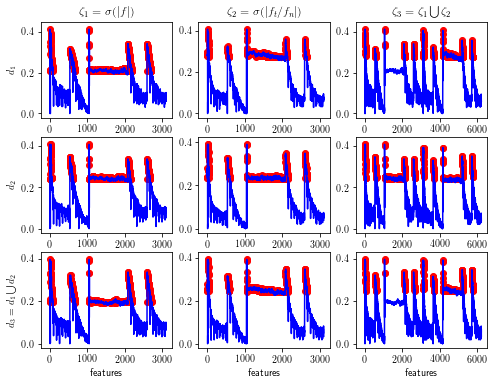

In [29]:
############################### DIMENSIONALITY REDUCTION VIA FEATURE SELECTION #####################################
fig = plt.figure(figsize=(8,6))
r,c = np.array(featsel).shape[0],np.array(featsel).shape[1]
Xfs = {}
matplotlib.rcParams['text.usetex'] = True
for i in range(r):
    Xfs[i] = {}
    for j in range(c):
        Xfs[i][j] = np.array(featsel[i][j].transform(X[i][:,tmpind[j]]))[:,bestix[i][j][:nfeat]]
        print Xfs[i][j].shape
        ax = fig.add_subplot(r,c,i*c+j+1)
        ax.plot(featsel[i][j].scores_,'b')
        ax.scatter(bestix[i][j][:nfeat],featsel[i][j].scores_[bestix[i][j][:nfeat]],color='r')
        if i==0 and j==0:
            ax.set_title(r'$\zeta_1=\sigma(|f|)$')
            ax.set_ylabel(r'$d_1$')
        if i==0 and j==1:
            ax.set_title(r'$\zeta_2=\sigma(|f_t/f_n|)$')
        if i==0 and j==2:
            ax.set_title(r'$\zeta_3=\zeta_1\bigcup \zeta_2$')
        if i==1 and j==0:
            ax.set_ylabel(r'$d_2$')
        if i==2 and j==0:
            ax.set_ylabel(r'$d_3=d_1\bigcup d_2$')
        if i==2:
            ax.set_xlabel('features')
Xfs = np.array([[i for _,i in Xfsi.items()] for _,Xfsi in Xfs.items()])
#plt.show()
savefig('plots/'+featname+'_featsel.png', bbox_inches='tight')
savefig('plots/featureselection.eps',format='eps',dpi=50,bbox_inches='tight')

(891, 20) (891,) [ 0.58315657  0.3171642   0.0375187   0.00885958  0.0033831   0.00252567
  0.00205616  0.0020025   0.00178099  0.00164826  0.00154477  0.00146149
  0.00136279  0.00133815  0.00123683  0.00113525  0.00108324  0.00106725
  0.00101352  0.0009424 ]
(891, 20) (891,) [  9.07557916e-01   5.59616249e-02   7.53767927e-03   6.21177430e-03
   3.63677708e-03   2.03916308e-03   1.76328001e-03   1.57624099e-03
   1.34628683e-03   1.00888014e-03   9.23444766e-04   8.97217111e-04
   8.68886927e-04   7.64186000e-04   6.55250138e-04   6.50811051e-04
   5.37426270e-04   4.87598791e-04   4.10828222e-04   3.98147209e-04]
(891, 20) (891,) [ 0.74092334  0.16030907  0.0183614   0.01760777  0.00776418  0.0051445
  0.00369517  0.00283489  0.00247834  0.00223629  0.00215205  0.00181562
  0.00174429  0.00142855  0.00136511  0.00127336  0.00119969  0.00115416
  0.00110138  0.00102958]
(891, 20) (891,) [ 0.69676952  0.23906691  0.02028578  0.00752241  0.0019919   0.0019105
  0.0018573   0.00175851 

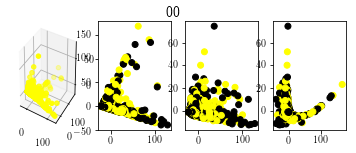

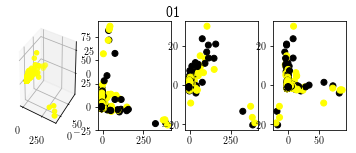

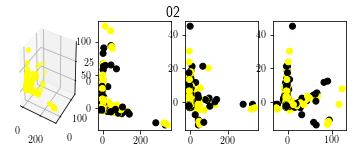

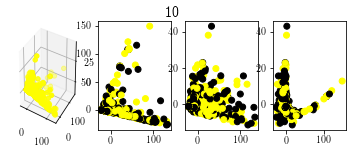

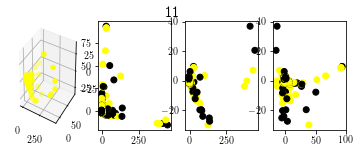

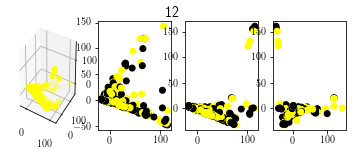

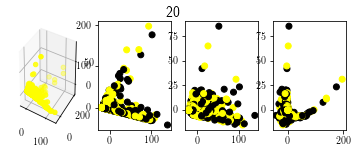

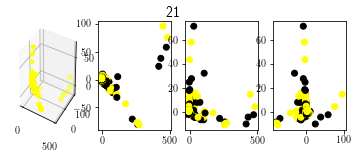

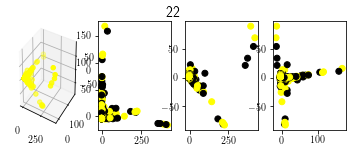

In [30]:
################################### DIMENSIONALITY REDUCTION PCA ##################################################
featdimredfile = featpath+featname+'_dimred'+'.npz'
ncomp = 20
tmpskip = 10
if os.path.isfile(featdimredfile):
    inpdimred = np.load(featdimredfile)
    pca = inpdimred['pca'].tolist()
    Xpca = inpdimred['Xpca']
    tmpix = inpdimred['tmpix']
else:
    # PCA
    r,c = Xfs.shape[0],Xfs.shape[1]
    Xpca,pca,tmpix = {},{},{}
    for i in range(r):
        Xpca[i],pca[i] = {},{}
        tmpix[i] = range(0,Xfs[i][0].shape[0],tmpskip)
        for j in range(c):
            pca[i][j] = PCA(n_components=ncomp, random_state=0)
            pca[i][j].fit(Xfs[i][j][tmpix[i],:])
            Xpca[i][j] = pca[i][j].transform(Xfs[i][j][tmpix[i],:])
    pca = np.array([[i for _,i in pcai.items()] for _,pcai in pca.items()])
    Xpca = np.array([[i for _,i in Xpcai.items()] for _,Xpcai in Xpca.items()])
    tmpix = np.array([i for _,i  in tmpix.items()])
    np.savez(featdimredfile,pca=pca,Xpca=Xpca,tmpix=tmpix)
for i in range(r):
    for j in range(c):
        print Xpca[i][j].shape, np.array(tmpix[i]).shape ,(pca[i][j].explained_variance_ratio_)
        ################################## VISUALIZATION OF DIMENSIONALITY REDUCTION ###############################
        fig = plt.figure(figsize=(6,2))
        fig.suptitle(str(i)+str(j), fontsize=14, fontweight='bold')
        #ax = Axes3D(fig)
        #fig = plt.figure()
        #ax = fig.add_subplot(111, projection='3d')
        ax = fig.add_subplot(141, projection='3d')
        #ax = fig.add_subplot(141)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,1],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(142)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,1],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(143)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(144)
        ax.scatter(Xpca[i][j][:,1],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))

(9, 2)
Dataset size and plots of 2 first X1 cols and Y1
(891, 20) (891,)
(891, 20) (891,)
(890, 20) (890,)
(891, 20) (891,)
(891, 20) (891,)
(890, 20) (890,)
(891, 20) (891,)
(891, 20) (891,)
(890, 20) (890,)


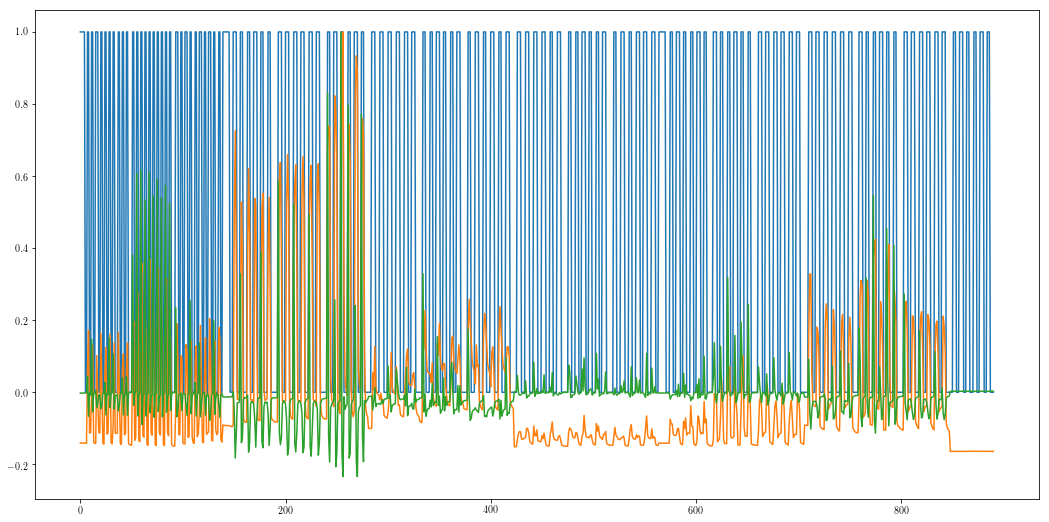

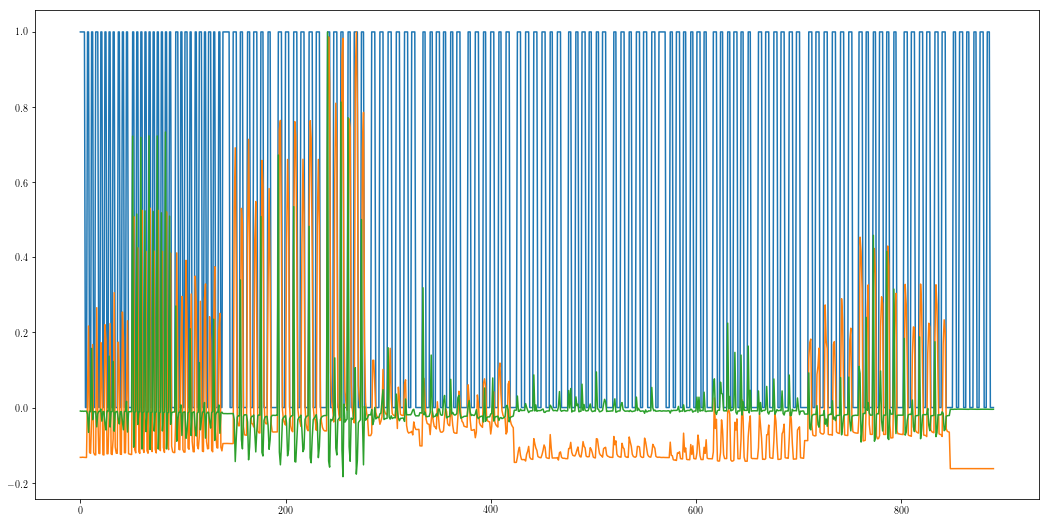

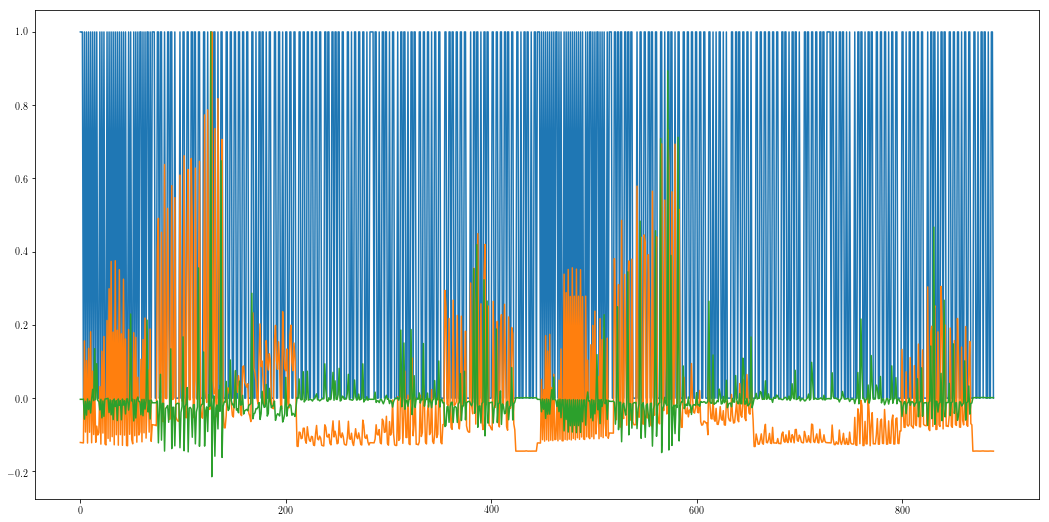

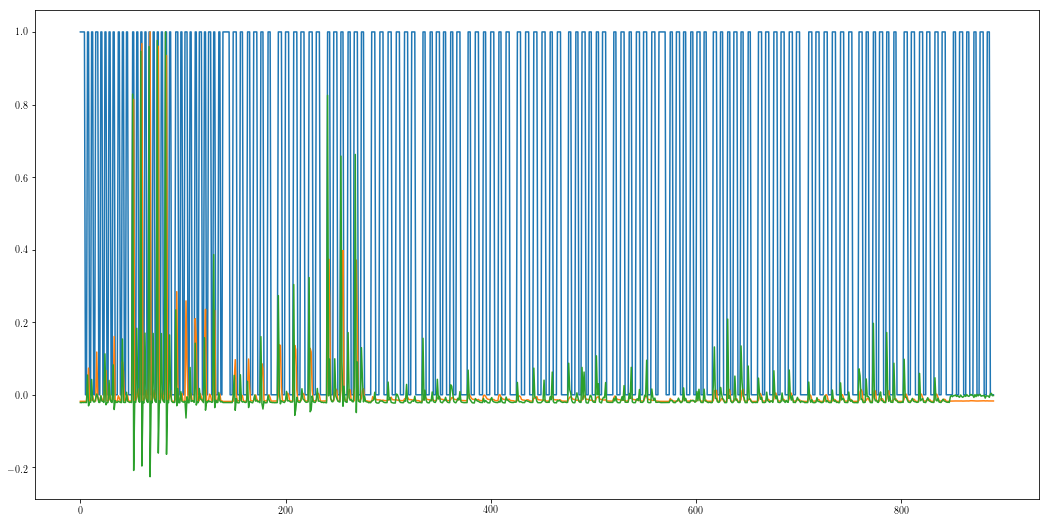

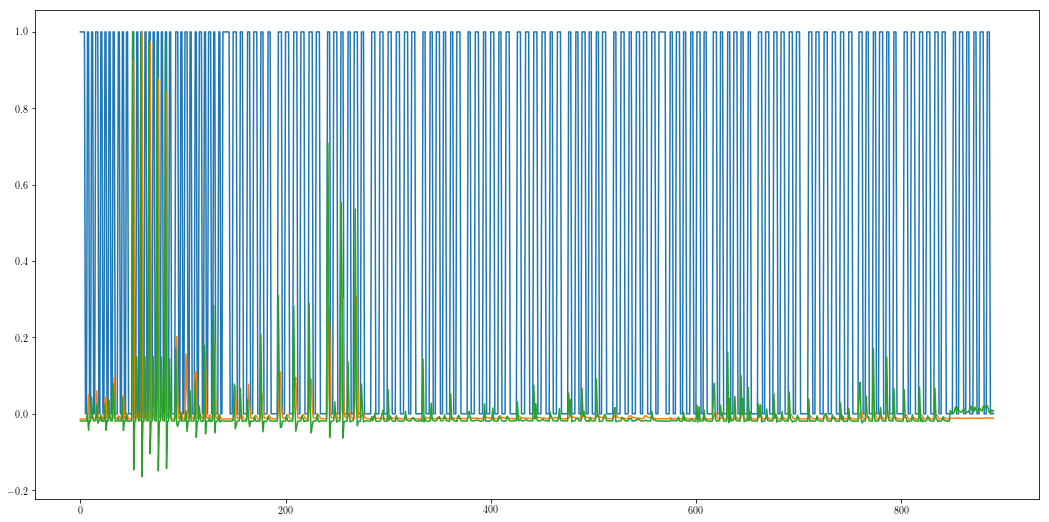

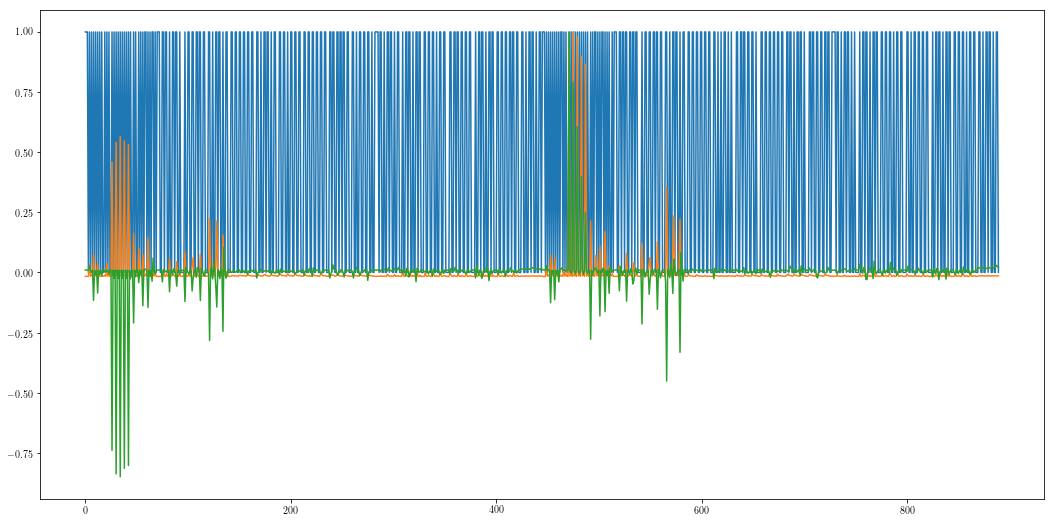

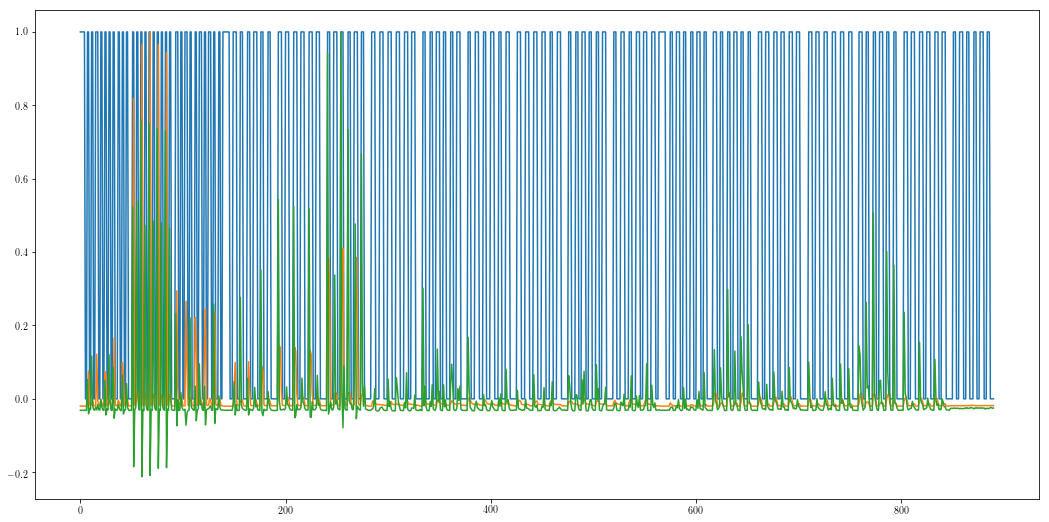

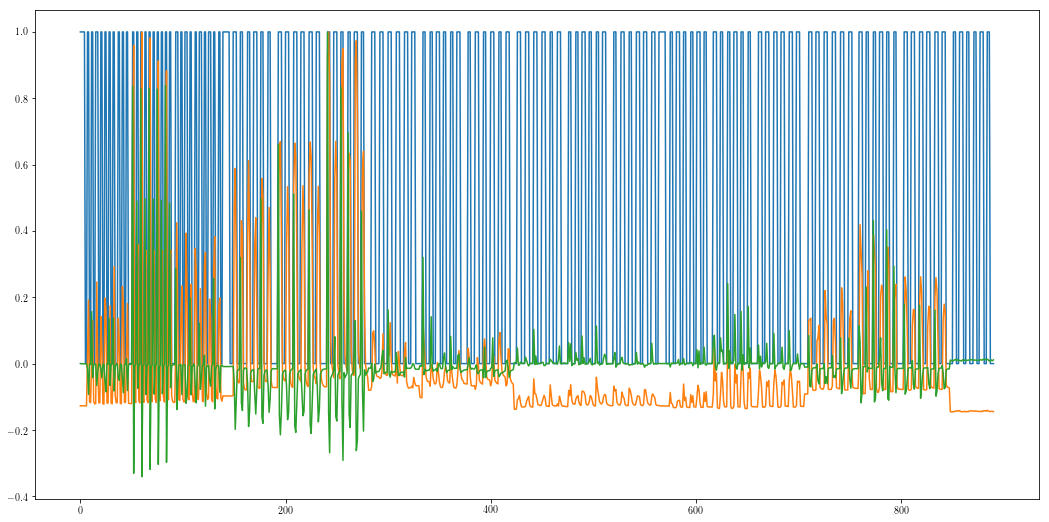

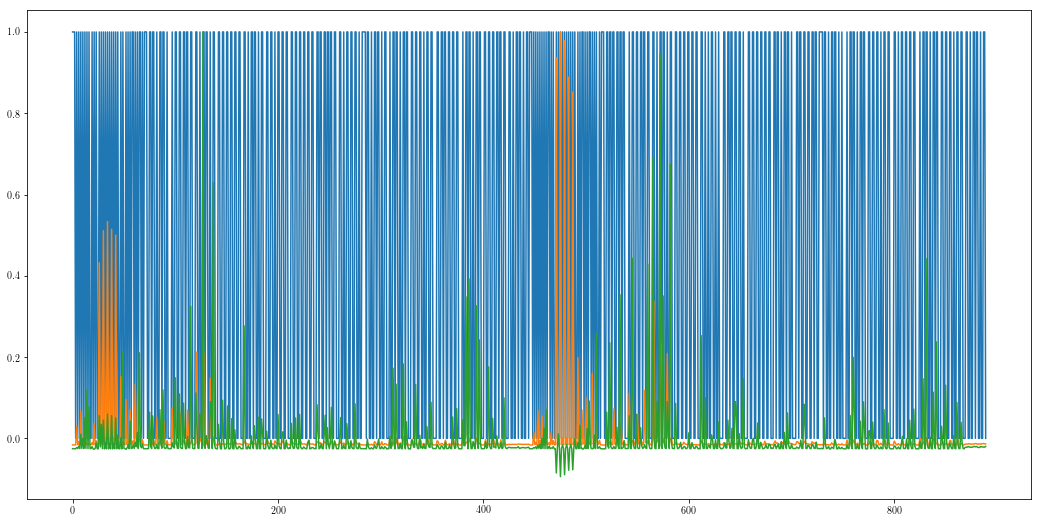

In [31]:
######################################## DATASETS PREPARATION ######################################################
datasets = [(Xpca[i][j],Y[i][tmpix[i]]) for j in range(c) for i in range(r)]
print np.array(datasets).shape
print "Dataset size and plots of 2 first X1 cols and Y1"
for ds in datasets:
    X1,Y1 = ds
    print X1.shape,Y1.shape
    plt.figure(figsize=(18,9))
    plt.plot(Y1)
    plt.hold
#     plt.plot(X1[:,:2])
    plt.plot(X1[:,:2]/np.max(X1[:,:2],axis=0))

In [47]:
# grid = [gs_fun(clf,parameters[clf_ind], cv, X,Y) for (clf_ind,clf) in enumerate(classifiers) for X,Y in datasets]

xmin,xmax,ymin,ymax:  -21.6241899933 129.180196883 -39.8455354045 168.410709248
Fitting... 
NearNb
1 0.829131652661 0.826330532213 0.804128882886 0.0304557854643 0.837622998264 0.0297474806306 --secs: 1.97887420654e-05
Fitting... 
RBFSVM1
2 0.817927170868 0.913165266106 0.784564923789 0.049464031133 0.907428130426 0.0232742959738 --secs: 2.71797180176e-05
Fitting... 
MLP1
3 0.798319327731 0.921568627451 0.812348060969 0.0326429055096 0.890912598881 0.0215032826783 --secs: 2.19345092773e-05
Fitting... 
RandFor
4 0.787114845938 0.927170868347 0.804051707505 0.028449519041 0.926837738761 0.0350875219778 --secs: 4.79221343994e-05
EnsembleMLP
Fitting... 
5 0.806722689076 0.932773109244 0.806637082771 0.0353357492392 0.932548716959 0.0450304625966 --secs: 0.000265121459961
xmin,xmax,ymin,ymax:  -22.2702212146 134.209846663 -28.0579306775 150.154387982
Fitting... 
NearNb
6 0.885154061625 0.840336134454 0.868192488263 0.0406551566139 0.820657276995 0.0627182917211 --secs: 2.19345092773e-05
Fit

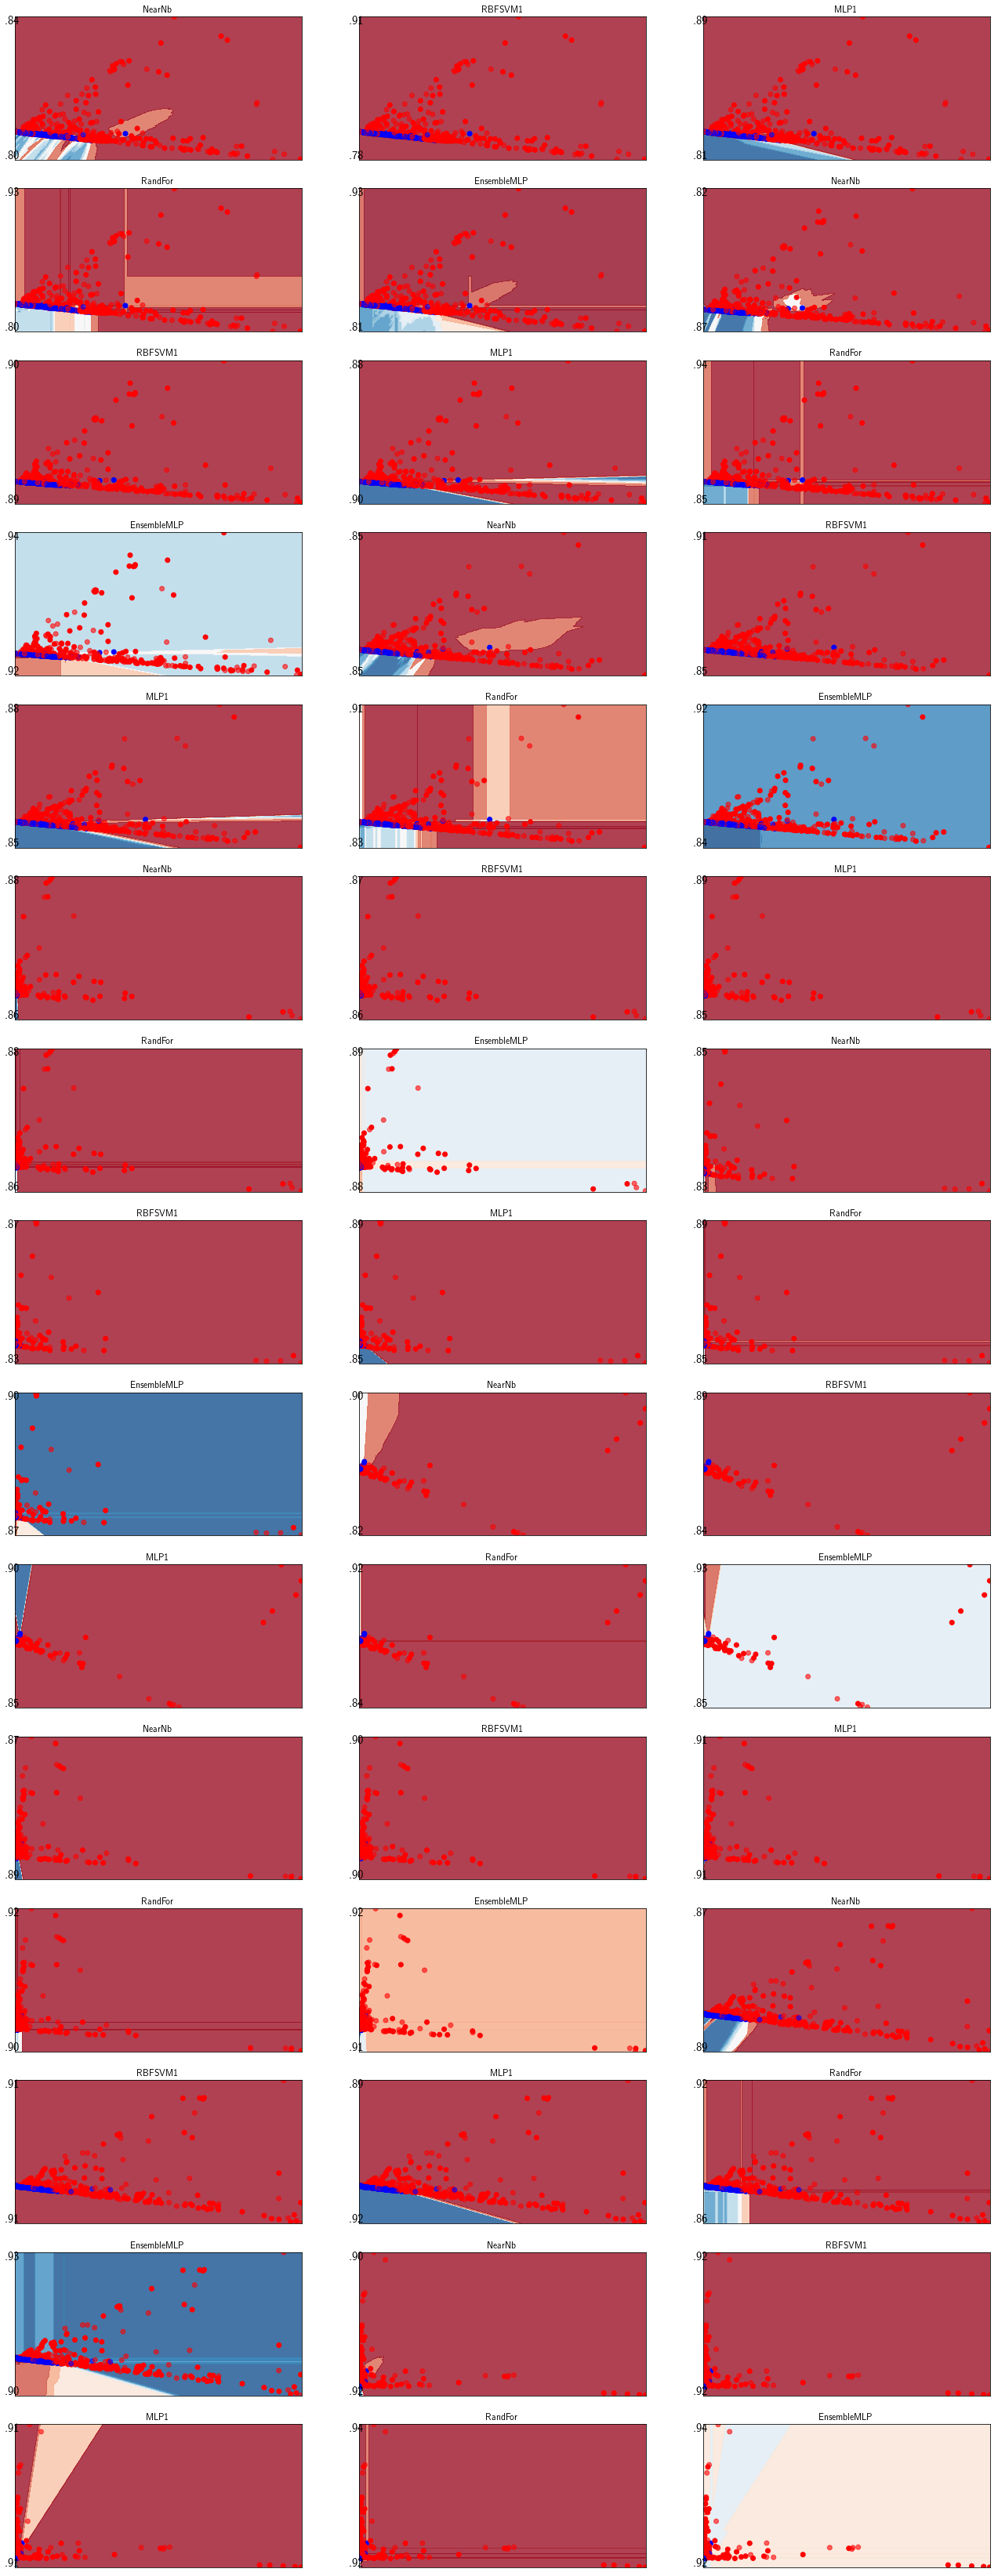

In [32]:
######################################### TRAINING OF ML CLASSIFIERS ###############################################
figure = plt.figure(figsize=(18, 72))
i = 1

#clffile = datapath+'trained_classifiers_'+str(window)+'_'+str(shift)+'.npz'
clffile = clfmodelfile
if os.path.isfile(clffile):
    clfall = np.load(clffile)['clfall']
    clfpall = np.load(clffile)['clfpall']
else:
    clfall = []
    clfpall = []
# iterate over datasets
start_time = time.time()
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    ncomp = 2
    # Keep the first ncomp of pca of X to visualize the results
    Xp = X[:,:ncomp]

    X_train, X_test, y_train, y_test, Xp_train, Xp_test = train_test_split(X, y, Xp, test_size=.4)
    
    x_min, x_max = Xp[:, 0].min() - .5, Xp[:, 0].max() + .5
    y_min, y_max = Xp[:, 1].min() - .5, Xp[:, 1].max() + .5
    print "xmin,xmax,ymin,ymax: ",x_min, x_max, y_min, y_max
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # just pick the colors used to represent the labels first
    cm = plt.cm.RdBu_r
    cm_bright = ListedColormap(['#0000FF', '#FF0000']) # blue:0 (stable), red: 1 (slip)
    
    clfmodels = []
    clfpmodels = []
    pred = []
    predp = []
    predts = []
    predpts = []
    score = []
    scorep = []
    scorec = []
    scorepc = []
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        tmpix = (i-1)%len(classifiers)
        ax = plt.subplot(len(datasets)*2, ceil(len(classifiers)/2.), i)
        if os.path.isfile(clffile):
            clfp = clfpall[i-1]
        else:
            clfp = deepcopy(clf)
        if i%(len(names))!=0:
            if not os.path.isfile(clffile):
                print "Fitting... "
                clf.fit(X_train, y_train)
                clfp.fit(Xp_train,y_train)
#             if i%(len(names)) == 8: # LASSOCV
            print names[(i-1)%len(names)]
            if names[(i-1)%(len(names))] == "Lasso":
                if not os.path.isfile(clffile):
                    print 
                    model = SelectFromModel(clf, prefit=True)
                else:
                    model = SelectFromModel(clfall[i-1], prefit=True)
                X_new = model.transform(X_train)
                print X_train.shape, X_new.shape
        else: # if classifier is ensemble mlp
            print names[(i-1)%len(names)]
            newX_train = np.array(pred).transpose()
            newXp_train = np.array(predp).transpose()
            if not os.path.isfile(clffile):
                print "Fitting... "
                clf.fit(newX_train,y_train)
                clfp.fit(newXp_train,y_train)
        if not os.path.isfile(clffile):
            clfmodels += [clf]
        else:
            clfmodels += [clfall[i-1]]
        clfpmodels += [clfp]
        if i%(len(names))!=0:
            if not os.path.isfile(clffile):
                npred = clf.predict(X_test)
            else:
                npred = clfall[i-1].predict(X_test)
            npredp = clfp.predict(Xp_test)
            t1 = time.time()
            score += [sum(((npred>0.5).astype(int)==y_test).astype(int))*1./len(y_test)]
            t2 = (time.time()-t1)
            scorep += [sum(((npredp>0.5).astype(int)==y_test).astype(int))*1./len(y_test)]
            try:
                if not os.path.isfile(clffile):
                    scorec += [cross_val_score(clf,X_test,y_test,cv=CV,scoring=metr)]
                else:
                    scorec += [cross_val_score(clfall[i-1],X_test,y_test,cv=CV,scoring=metr)]
                scorepc += [cross_val_score(clfp,Xp_test,y_test,cv=CV,scoring=metr)]
            except ValueError:
                scorec += [np.array(score[tmpix])]
                scorepc += [np.array([scorep[tmpix]])]      
            if not os.path.isfile(clffile):
                if hasattr(clf, "predict_proba"):
                    pred += [clf.predict_proba(X_train)[:,1]]
                    predts += [clf.predict_proba(X_test)[:,1]]
                else:
                    pred += [clf.predict(X_train)]
                    predts += [clf.predict(X_test)]
            else:
                if hasattr(clf, "predict_proba"):
                    pred += [clfall[i-1].predict_proba(X_train)[:,1]]
                    predts += [clfall[i-1].predict_proba(X_test)[:,1]]
                else:
                    pred += [clfall[i-1].predict(X_train)]
                    predts += [clfall[i-1].predict(X_test)]
            if hasattr(clfp, "predict_proba"):
                predp += [clfp.predict_proba(Xp_train)[:,1]]
                predpts += [clfp.predict_proba(Xp_test)[:,1]]
            else:
                predp += [clfp.predict(Xp_train)]
                predpts += [clfp.predict(Xp_test)]
        else: # if classifier is ensemble MLP
            newX_test = np.array(predts).transpose()
            newXp_test = np.array(predpts).transpose()
            t1 = time.time()
            if not os.path.isfile(clffile):
                score += [clf.score(newX_test, y_test)]
            else:
                score += [clfall[i-1].score(newX_test, y_test)]
            t2 = (time.time()-t1)#*1./len(y_test)
            scorep += [clfp.score(newXp_test, y_test)]
            try:
                if not os.path.isfile(clffile):
                    scorec += [cross_val_score(clf,newX_test,y_test,cv=CV,scoring=metr)]
                else:
                    scorec += [cross_val_score(clfall[i-1],newX_test,y_test,cv=CV,scoring=metr)]
                scorepc += [cross_val_score(clfp,newXp_test,y_test,cv=CV,scoring=metr)]
            except ValueError:
                scorec += [np.array(score[tmpix])]
                scorepc += [np.array([scorep[tmpix]])]
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]*[y_min, y_max].
        Zlist = []
        if i%(len(names))!=0:
            if not hasattr(clfp, "predict_proba"):
                Z = clfp.predict(np.c_[xx.ravel(), yy.ravel()])
            else:
                try:
                    Z = clfp.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                except MemoryError:
                    print "Memory Error Handled!"
                    Z = clfp.predict(np.c_[xx.ravel(), yy.ravel()])
            Zlist += [Z]
        else: # if classifier is ensemble MLP
            Z = np.zeros((np.c_[xx.ravel(), yy.ravel()].shape[0]))
            j = 0
            for clfpi in clfpmodels:
                if j >= len(clfmodels)-1:
                    continue
                mult = (clfp.intercepts_[0][:,np.newaxis]*clfp.intercepts_[1]*clfp.intercepts_[2])[:,0]
                if not hasattr(clfpi, "predict_proba"):
                    #Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
                    #Z += clf.intercepts_[0][j]*clfpi.decision_function(np.c_[xx.ravel(), yy.ravel()])
                    #Z += clf.intercepts_[0][j]*clfpi.predict(np.c_[xx.ravel(), yy.ravel()])
                    Z += mult[j]*clfpi.predict(np.c_[xx.ravel(), yy.ravel()])
                else:
                    #Z += clf.intercepts_[0][j]*clfpi.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                    Z += mult[j]*clfpi.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                j += 1
                Zlist += [Z]
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(Xp_train[:, 0], Xp_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(Xp_test[:, 0], Xp_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.min()+0.02*(xx.max()-xx.min()), yy.max()-0.05*(yy.max()-yy.min()), ('%.2f' % scorec[tmpix].mean()).lstrip('0'),
                size=15, horizontalalignment='right')
        ax.text(xx.min()+0.02*(xx.max()-xx.min()), yy.min()+0.01*(yy.max()-yy.min()), ('%.2f' % scorepc[tmpix].mean()).lstrip('0'),
                size=15, horizontalalignment='right')
        print i, scorep[tmpix], score[tmpix], scorepc[tmpix].mean(), scorepc[tmpix].std(),\
               scorec[tmpix].mean(), scorec[tmpix].std() , '--secs:', t2
        i += 1
    if not os.path.isfile(clffile):
        clfall += deepcopy(clfmodels)
        clfpall += deepcopy(clfpmodels)
figure.subplots_adjust(left=.02, right=.98)
print("--- %s seconds ---" % (time.time() - start_time))
#plt.show()
savefig('plots/'+featname+'.png', bbox_inches='tight')

In [33]:
########################################## Saving/Loading ML Models ################################################
if not os.path.isfile(clffile):
    np.savez(clffile,clfall=np.array(clfall),clfpall=np.array(clfpall))
else:
    clfall = np.load(clffile)['clfall']
print np.array(clfall).shape

(45,)


In [35]:
################################# Saving STD, FEATSEL, PCA, ML Models for online usage #############################
# modelfile = datapath+'allmodels_trans_gs'+str(window)+'_'+str(shift)+'.npz'
if not os.path.isfile(modelfile):
    np.savez(modelfile,clfall=np.array(clfall),bestsel=bestix,stdtran=S,pca=pca)
else:
    clfall = np.load(modelfile)['clfall']
    bestsel = np.load(modelfile)['bestsel']
    stdtran = np.load(modelfile)['stdtran']
    pca = np.load(modelfile)['pca']
    print np.array(clfall).shape, bestsel.shape, stdtran.shape, pca.shape

(45,) (3, 3) (3, 3) (3, 3)


In [36]:
################################### Computing test inputs for validation ###########################################
ix = [[0,3,6],[1,4,7],[2,5,8]]
dsfile = featpath+featname+'_testds'+'.npz'
S = stdtran
bestix = bestsel
if os.path.isfile(dsfile):
    ds = np.load(dsfile)['ds']
else:
    ds = {}
#     X = np.load(XYfile)['X']
#     Y = np.load(XYfile)['Y']
    X = np.load(XYsplitfile)['Xsp']
    Y = np.load(XYsplitfile)['Ysp']
    r = X.shape[0]
    c = 3
#     tmpind = {}
#     tmpind[2] = range(X[0].shape[1])
#     tmpind[0] = range(X[0].shape[1]/2)
#     tmpind[1] = range(X[0].shape[1]/2,X[0].shape[1])
#     tmpind = np.array([i for _,i in tmpind.items()])
    rng = np.random.RandomState(2)
    X += 0.0 * rng.uniform(size=X.shape)
    for i in range(r): # for all datasets (take each scaler and pca)
        ds[i] = {} 
        for j in range(r): # for all datasets as well (transform all of them with the given scaler and pca)
            ds[i][j] = {}
            for k in range(c): # for all feature dimensions
#                 tmpnorm = S[i][k].transform(X[j][:,tmpind[k]])
                tmpnorm = S[i][k].transform(X[j][k])
                #Xfs[i][k] = np.array(featsel[i][k].transform(tmpnorm))[:,bestix[i][k][:nfeat]]
                tmpfs = np.array(tmpnorm)[:,bestix[i][k][:nfeat]]
                ds[i][j][k] = pca[i][k].transform(tmpfs) # transform with pca(i,k) all Xfs(j,k) 
#                 print i,j,k,tmpfs.shape,ds[i][j][k].shape,Y[j].shape,X[j][:,tmpind[k]].shape,tmpnorm.shape
                print i,j,k,tmpfs.shape,ds[i][j][k].shape,Y[j].shape,X[j][k].shape,tmpnorm.shape
    ds = np.array([[[dsijk for _,dsijk in dsij.items()] for _,dsij in dsi.items()] for _,dsi in ds.items()])
    np.savez(dsfile,ds=ds)
print ds.shape

0 0 0 (8902, 1000) (8902, 20) (8902,) (8902, 3107) (8902, 3107)
0 0 1 (8902, 1000) (8902, 20) (8902,) (8902, 3107) (8902, 3107)
0 0 2 (8902, 1000) (8902, 20) (8902,) (8902, 6214) (8902, 6214)
0 1 0 (8902, 1000) (8902, 20) (8902,) (8902, 3107) (8902, 3107)
0 1 1 (8902, 1000) (8902, 20) (8902,) (8902, 3107) (8902, 3107)
0 1 2 (8902, 1000) (8902, 20) (8902,) (8902, 6214) (8902, 6214)
0 2 0 (8898, 1000) (8898, 20) (8898,) (8898, 3107) (8898, 3107)
0 2 1 (8898, 1000) (8898, 20) (8898,) (8898, 3107) (8898, 3107)
0 2 2 (8898, 1000) (8898, 20) (8898,) (8898, 6214) (8898, 6214)
1 0 0 (8902, 1000) (8902, 20) (8902,) (8902, 3107) (8902, 3107)
1 0 1 (8902, 1000) (8902, 20) (8902,) (8902, 3107) (8902, 3107)
1 0 2 (8902, 1000) (8902, 20) (8902,) (8902, 6214) (8902, 6214)
1 1 0 (8902, 1000) (8902, 20) (8902,) (8902, 3107) (8902, 3107)
1 1 1 (8902, 1000) (8902, 20) (8902,) (8902, 3107) (8902, 3107)
1 1 2 (8902, 1000) (8902, 20) (8902,) (8902, 6214) (8902, 6214)
1 2 0 (8898, 1000) (8898, 20) (8898,) (8

In [37]:
################################### Computing test outputs for evaluation ##########################################
ftsnames = ['sf','ftn','all']
outfile = featpath+featname+'_testout_all'+'.npz'
if os.path.isfile(outfile):
    tmpout = np.load(outfile)['tmpout']
    tmpfsc = np.load(outfile)['tmpfsc']
    tmpauc = np.load(outfile)['tmpauc']
else: 
    tmpout = {}
    tmpfsc = {}
    tmpauc = {}
    tmppred = {}
    for i in range(r):
        tmpout[i] = {}
        tmppred[i] = {}
        tmpfsc[i] = {}
        tmpauc[i] = {}
        for j in range(r):
            tmpY = Y[j]==-1
            tmpout[i][j] = {}
            tmpfsc[i][j] = {}
            tmpauc[i][j] = {}
            tmppred[i][j] = {}
            for k in range(c):
                tmpout[i][j][k] = {}
                tmppred[i][j][k] = {}
                tmpfsc[i][j][k] = {}
                tmpauc[i][j][k] = {}
                for l in range(len(names)):
                    if (l+1)%len(names)!=0: # not ensemble
                        tmpout[i][j][k][l] = clfall[ix[i][k]*len(names)+l].score(ds[i][j][k],Y[j])
                        tmppred[i][j][k][l] = clfall[ix[i][k]*len(names)+l].predict(ds[i][j][k])
                    else:
                        tmpin = np.array([tpred for _,tpred in tmppred[i][j][k].items()]).transpose()
                        tmpout[i][j][k][l] = clfall[ix[i][k]*len(names)+l].score(tmpin,Y[j])
                        tmppred[i][j][k][l] = clfall[ix[i][k]*len(names)+l].predict(tmpin)
                    tmpfsc[i][j][k][l] = f1_score(Y[j],np.round(np.divide(np.abs(tmppred[i][j][k][l]),np.finfo(float).eps+np.amax(np.abs(tmppred[i][j][k][l])))))
                    tmpauc[i][j][k][l] = roc_auc_score(Y[j],np.round(np.divide(np.abs(tmppred[i][j][k][l]),np.finfo(float).eps+np.amax(np.abs(tmppred[i][j][k][l])))))
                    print i,j,k,l,ds[i][j][k].shape,Y[j].shape,tmpout[i][j][k][l],tmpfsc[i][j][k][l],tmpauc[i][j][k][l]
    tmpout = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpout.items()])
    tmppred = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmppred.items()])
    tmpfsc = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpfsc.items()])
    tmpauc = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpauc.items()])
    np.savez(outfile,tmpout=tmpout,tmppred=tmppred,tmpfsc=tmpfsc,tmpauc=tmpauc)
print tmpout[:,:,:,-1],tmpfsc[:,:,:,-1],tmpauc[:,:,:,-1]

0 0 0 0 (8902, 20) (8902,) 0.846551336778 0.819978914075 0.841491132928
0 0 0 1 (8902, 20) (8902,) 0.898225117951 0.887565152643 0.895750671902
0 0 0 2 (8902, 20) (8902,) 0.91417658953 0.90358404846 0.911032081577
0 0 0 3 (8902, 20) (8902,) 0.930689732644 0.923439632709 0.928291598748
0 0 0 4 (8902, 20) (8902,) 0.921028982251 0.914403993669 0.919419897788
0 0 1 0 (8902, 20) (8902,) 0.902718490227 0.895081172765 0.901285032575
0 0 1 1 (8902, 20) (8902,) 0.897214109189 0.896528327491 0.898867328773
0 0 1 2 (8902, 20) (8902,) 0.927207369131 0.921110299489 0.925617067506
0 0 1 3 (8902, 20) (8902,) 0.910694226017 0.907911502375 0.911272139605
0 0 1 4 (8902, 20) (8902,) 0.927432037744 0.921392066196 0.925863271789
0 0 2 0 (8902, 20) (8902,) 0.895416760279 0.881597354699 0.8919102746
0 0 2 1 (8902, 20) (8902,) 0.919905639182 0.912354025814 0.917883738867
0 0 2 2 (8902, 20) (8902,) 0.933947427544 0.928588778237 0.932477096855
0 0 2 3 (8902, 20) (8902,) 0.925522354527 0.919489981785 0.924038845

2 1 2 1 (8902, 20) (8902,) 0.900584138396 0.887476160203 0.897099483882
2 1 2 2 (8902, 20) (8902,) 0.914288923837 0.907548770144 0.912875527927
2 1 2 3 (8902, 20) (8902,) 0.925073017299 0.921557097495 0.924998471024
2 1 2 4 (8902, 20) (8902,) 0.907099528196 0.901535897131 0.906438502526
2 2 0 0 (8898, 20) (8898,) 0.849179590919 0.830641090358 0.845991342253
2 2 0 1 (8898, 20) (8898,) 0.900988986289 0.892364080635 0.899203899489
2 2 0 2 (8898, 20) (8898,) 0.901775679928 0.894469934798 0.900475793418
2 2 0 3 (8898, 20) (8898,) 0.920656327265 0.913267813268 0.918685501725
2 2 0 4 (8898, 20) (8898,) 0.910654079568 0.906569514632 0.910503486951
2 2 1 0 (8898, 20) (8898,) 0.896718363677 0.888565538984 0.895234027268
2 2 1 1 (8898, 20) (8898,) 0.885817037537 0.885893980234 0.887587173785
2 2 1 2 (8898, 20) (8898,) 0.930096650933 0.92589945199 0.92941084877
2 2 1 3 (8898, 20) (8898,) 0.902562373567 0.901151522061 0.903702251079
2 2 1 4 (8898, 20) (8898,) 0.92762418521 0.923624288425 0.92712299

In [38]:
### Computing stats for assessment #################################################
# mean of all test datasets, for each train dataset, for each ft, for each clf
meantsds = np.mean(tmpout,axis=1)
# mean of all test datasets, of all train datasets, for each ft, for each clf
meanft = np.mean(meantsds,axis=0)
# mean of all test datasets, of all ft, for each train dataset, for each clf
meantrds = np.mean(meantsds,axis=1)
# mean of all test datasets, of all train datasets, of all ft, for each clf
meanclf1 = np.mean(meanft,axis=0)
meanclf2 = np.mean(meantrds,axis=0)

print tmpout.shape, meantsds.shape, meanft.shape, meantrds.shape, meanclf1.shape, meanclf2.shape
print '--------------------------------------------------------------------------------------------','ALL'
print 'Best 5 Mean Accuracy of Classifiers for alltestds and alltrainds for each ft: '
maxmeanft = np.array([sorted(zip(map(lambda x: round(x,4), meanft[i,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True) for i in range(meantrds.shape[0])])
print maxmeanft[:,:5,:]
print 'Best 5 Mean Accuracy of Classifiers for alltestds and allft for each trainds: '
maxmeantrds = np.array([sorted(zip(map(lambda x: round(x,4), meantrds[i,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True) for i in range(meantrds.shape[0])])
print maxmeantrds[:,:5,:]
print 'Best 5 Mean Accuracy of Classifiers for alltrainds, alltestds and allft: '
maxmeanclf1 = sorted(zip(map(lambda x: round(x,4), meanclf1),map(lambda x: x[:4], names),range(len(names))),reverse=True)
print maxmeanclf1[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanAll'
for i in range(meantsds.shape[0]):
    for j in range(meantsds.shape[1]):
        print 'Best 5 Mean Accuracy of Classifiers for trainds['+str([i,j])+'], testds['+str([i,j])+'] and ft['+str([i,j])+'] (version with all): '
        maxclf1 = sorted(zip(map(lambda x: round(x,4), meantsds[i,j,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
        print maxclf1[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanSelf'
for i in range(tmpout.shape[0]):
    for j in range(tmpout.shape[2]):
        print 'Best 5 Self Accuracy of Classifiers for tmpout['+str([i,i,j])+']: '
        maxclf = sorted(zip(map(lambda x: round(x,4), tmpout[i,i,j,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
        print maxclf[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanCross'
for i in range(tmpout.shape[0]):
    for j in range(tmpout.shape[1]):
        for k in range(tmpout.shape[2]):
            if i!=j:
                print 'Best 5 Mean Cross Accuracy of Classifiers for tmpout['+str([i,j,k])+']: '
                maxclf = sorted(zip(map(lambda x: round(x,4), tmpout[i,j,k,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
                print maxclf[:5]
print '--------------------------------------------------------------------------------------------','EACH'
for i in range(len(names)):
    print '--------------------------------------------------------------------------------------------',i
    print 'Accuracy of '+str(names[i])+' in classifying (trainds,testds,ft): '
    print tmpout[:,:,:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds for each trainds and each ft: '
    print meantsds[:,:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds and alltrainds for each ft: '
    print meanft[:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds and allft for each trainds: '
    print meantrds[:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltrainds, alltestds and allft: '
    print meanclf1[i],' or mean(', tmpout[-1,:,-1,i],') = ',meantsds[-1,-1,i]

(3, 3, 3, 5) (3, 3, 5) (3, 5) (3, 5) (5,) (5,)
-------------------------------------------------------------------------------------------- ALL
Best 5 Mean Accuracy of Classifiers for alltestds and alltrainds for each ft: 
[[['0.9176' 'Rand' '3']
  ['0.9039' 'Ense' '4']
  ['0.8911' 'MLP1' '2']
  ['0.888' 'RBFS' '1']
  ['0.8401' 'Near' '0']]

 [['0.9226' 'Ense' '4']
  ['0.9176' 'MLP1' '2']
  ['0.9091' 'Rand' '3']
  ['0.893' 'Near' '0']
  ['0.8862' 'RBFS' '1']]

 [['0.9111' 'MLP1' '2']
  ['0.9106' 'Rand' '3']
  ['0.9084' 'Ense' '4']
  ['0.8907' 'RBFS' '1']
  ['0.8651' 'Near' '0']]]
Best 5 Mean Accuracy of Classifiers for alltestds and allft for each trainds: 
[[['0.9191' 'Rand' '3']
  ['0.9143' 'MLP1' '2']
  ['0.9123' 'Ense' '4']
  ['0.898' 'RBFS' '1']
  ['0.8632' 'Near' '0']]

 [['0.9047' 'Ense' '4']
  ['0.9017' 'Rand' '3']
  ['0.8871' 'MLP1' '2']
  ['0.8692' 'RBFS' '1']
  ['0.8656' 'Near' '0']]

 [['0.9184' 'MLP1' '2']
  ['0.9179' 'Ense' '4']
  ['0.9165' 'Rand' '3']
  ['0.8977' 'RBFS' 

(38,) (38,)
(45,) (3, 3) (3, 3) (3, 3)
0 (522,) (522, 3107, 2)
(522,)
1 (520,) (520, 3107, 2)
(520,)
2 (523,) (523, 3107, 2)
(523,)
3 (534,) (534, 3107, 2)
(534,)
4 (538,) (538, 3107, 2)
(538,)
5 (534,) (534, 3107, 2)
(534,)
6 (539,) (539, 3107, 2)
(539,)
7 (534,) (534, 3107, 2)
(534,)
8 (538,) (538, 3107, 2)
(538,)
9 (539,) (539, 3107, 2)
(539,)
10 (534,) (534, 3107, 2)
(534,)
11 (538,) (538, 3107, 2)
(538,)
12 (534,) (534, 3107, 2)
(534,)
13 (534,) (534, 3107, 2)
(534,)
14 (538,) (538, 3107, 2)
(538,)
15 (539,) (539, 3107, 2)
(539,)
16 (534,) (534, 3107, 2)
(534,)
17 (538,) (538, 3107, 2)
(538,)
18 (534,) (534, 3107, 2)
(534,)
19 (522,) (522, 3107, 2)
(522,)
20 (520,) (520, 3107, 2)
(520,)
21 (523,) (523, 3107, 2)
(523,)
22 (534,) (534, 3107, 2)
(534,)
23 (538,) (538, 3107, 2)
(538,)
24 (534,) (534, 3107, 2)
(534,)
25 (539,) (539, 3107, 2)
(539,)
26 (534,) (534, 3107, 2)
(534,)
27 (538,) (538, 3107, 2)
(538,)
28 (539,) (539, 3107, 2)
(539,)
29 (534,) (534, 3107, 2)
(534,)
30 (538,) (

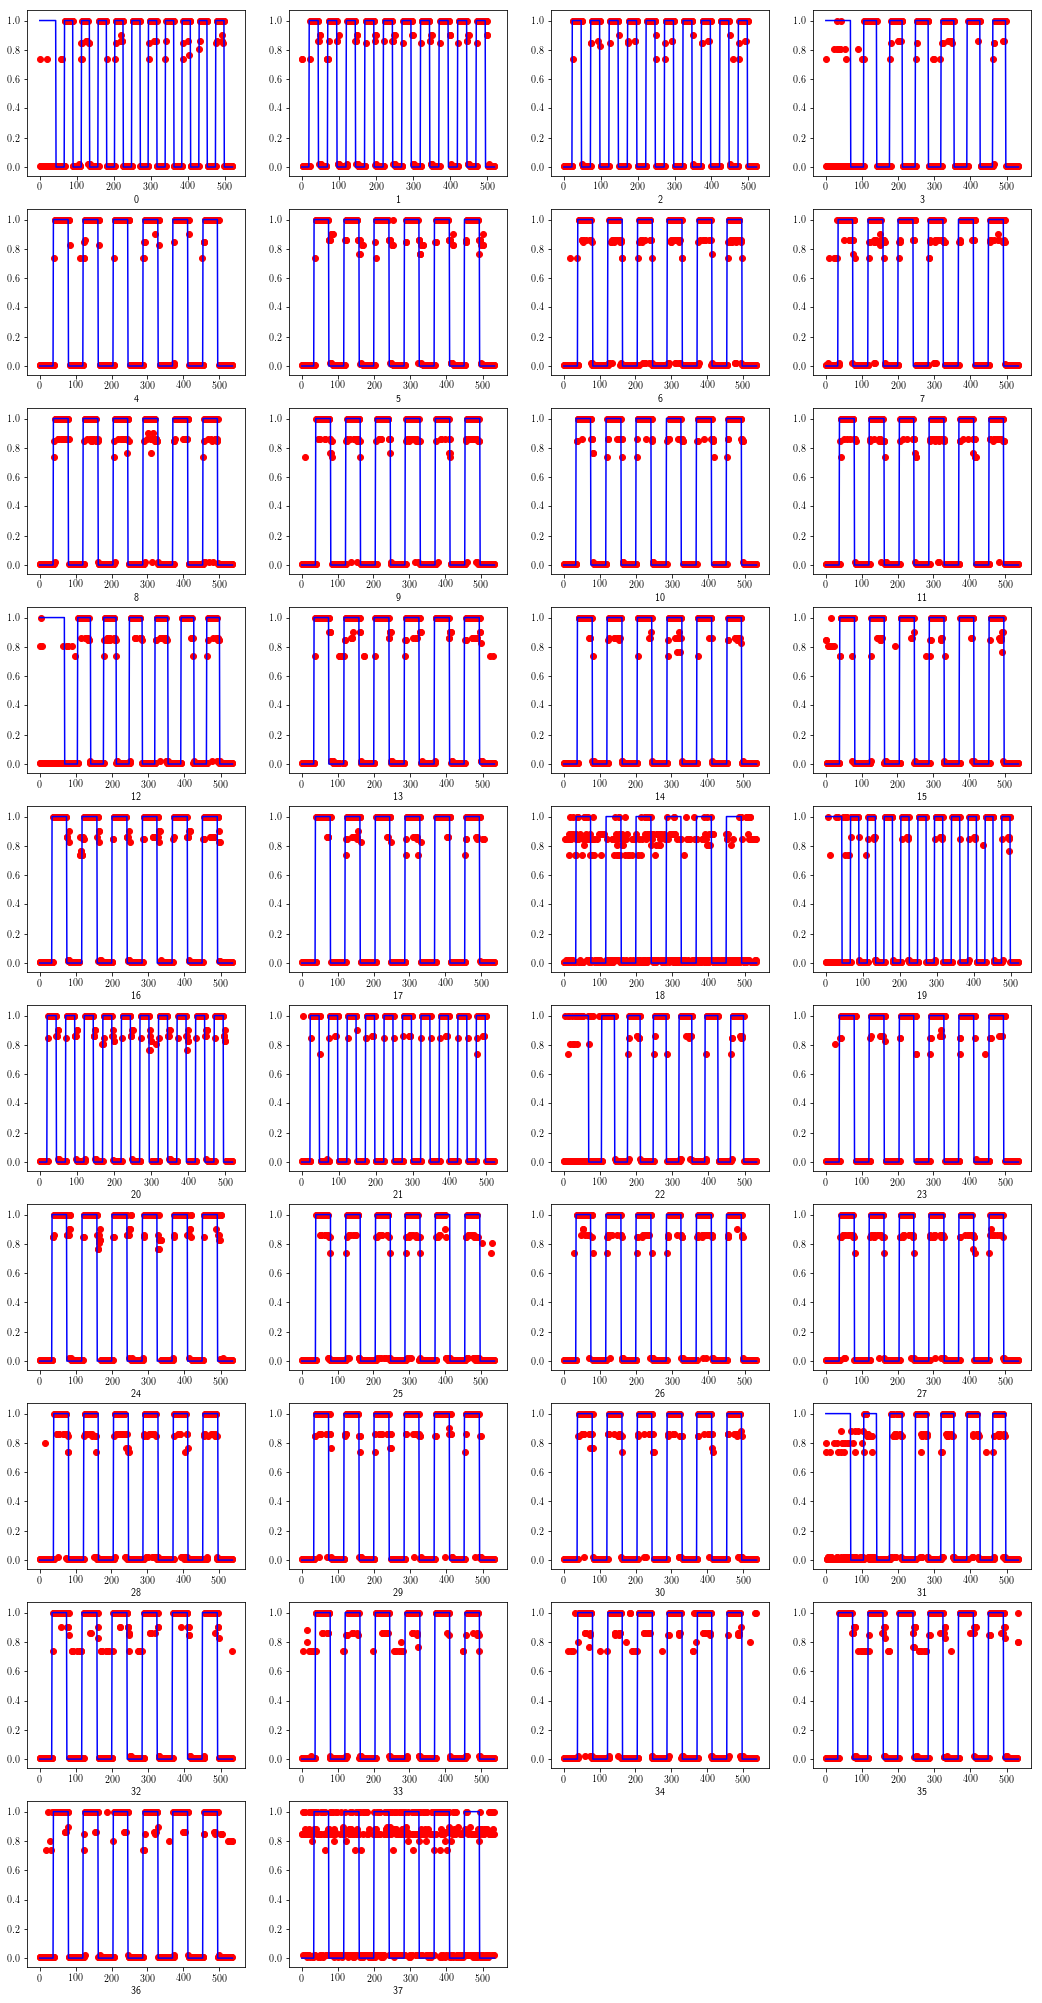

In [39]:
testfeat = np.load(featfile)['features']
testlabs = np.load(featfile)['labels']
print testfeat.shape, testlabs.shape
clfall = np.load(modelfile)['clfall']
bestsel = np.load(modelfile)['bestsel']
stdtran = np.load(modelfile)['stdtran']
pca = np.load(modelfile)['pca']
print np.array(clfall).shape, bestsel.shape, stdtran.shape, pca.shape
k = 8# keep k-th family of clfs, corresponding to clf[k1l(k),k2l(k)]
k1l = [0, 0 ,0, 1, 1, 1, 2, 2, 2]
k2l = [0, 1, 2, 0, 1, 2, 0, 1, 2]
kst1 = [0, 1, 0]
kst2 = [1, 2, 2]
k1, k2 = k1l[k], k2l[k]
# clf2use = [1,1,1,1,1,1,1,1]
# clf2use = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
clf2use = [1,1,1,1,1]
keepkbest = 1000 # features to keep for pca
allout = []
fig = plt.figure(figsize=(18,36))
r=10.
for ix in range(testfeat.shape[0]):
    print ix, testlabs[ix].shape, testfeat[ix].shape
    output = []
    for tfix in range(testfeat[ix].shape[0]):
        feats = np.array(testfeat[ix][tfix,:,kst1[k2]:kst2[k2]]).flatten(order='F')[np.newaxis,:]
        rng = np.random.RandomState(2)
        feats += 0.0 * rng.uniform(size=feats.shape)
#         print 'feats: ', feats.shape
        #raw_input()
        stdfeats = stdtran[k1,k2].transform(feats)
        #print 'stdtr: ', stdfeats.shape
        bestfeats = stdfeats[:,bestsel[k1,k2][:keepkbest]]
        #print 'bestf: ', bestfeats.shape
        pcafeats = pca[k1,k2].transform(bestfeats)
        #print 'pcatr: ', pcafeats.shape

        # Use trained classifiers for prediction
        acc = []
        clfout = []
        for i in range(len(names)):
            if clf2use[i] != 1 and clf2use[-1] != 1:
                continue
            clf = clfall[len(names)*k+i]
            if (i+1)%(len(names)) != 0:
                if hasattr(clf, "predict_proba"):
                    acc += [clf.predict_proba(pcafeats)[0,1]]
                else:
                    acc += [clf.predict(pcafeats)[0]]
            else:
                tmpclfin = np.array(clfout)[np.newaxis,:]
                acc += [clf.predict_proba(tmpclfin)[0,1]]
            clfout += [int(acc[-1]>0.5)]

        weights = np.ones(np.array(acc).shape)
        if clf2use[-1] == 0: # majority vote decision
            output.append(int(sum(weights*np.array(acc))>sum(weights)/2))
        else: # ensemble MLP decision
            output.append(acc[-1])
    print np.array(output).shape
    allout.append(output)
    ax = fig.add_subplot(int(r),int(np.ceil(testfeat.shape[0]/r)),ix+1)
    ax.plot(testlabs[ix],'b')
    ax.scatter(range(len(output)),output,color='r')
    ax.set_xlabel(str(ix))
print np.array(allout).shape

In [ ]:
# testfeat = np.load(featfile)['features']
# testlabs = np.load(featfile)['labels']
# print testfeat.shape, testlabs.shape
# clfall = np.load(modelfile)['clfall']
# bestsel = np.load(modelfile)['bestsel']
# stdtran = np.load(modelfile)['stdtran']
# pca = np.load(modelfile)['pca']
# print np.array(clfall).shape, bestsel.shape, stdtran.shape, pca.shape
# k = 8# keep k-th family of clfs, corresponding to clf[k1l(k),k2l(k)]
# k1l = [0, 0 ,0, 1, 1, 1, 2, 2, 2]
# k2l = [0, 1, 2, 0, 1, 2, 0, 1, 2]
# kst1 = [0, 1, 0]
# kst2 = [1, 2, 2]
# k1, k2 = k1l[k], k2l[k]
# # clf2use = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
# clf2use = [0,0,0,0,0,0,1,0,0,0,0,0,0,0]
# keepkbest = 1000 # features to keep for pca
# allout = []
# fig = plt.figure(figsize=(18,36))
# r=10.
# for ix in range(testfeat.shape[0]):
#     print ix, testlabs[ix].shape, testfeat[ix].shape
#     output = []
#     for tfix in range(testfeat[ix].shape[0]):
#         feats = np.array(testfeat[ix][tfix,:,kst1[k2]:kst2[k2]]).flatten(order='F')[np.newaxis,:]
#         rng = np.random.RandomState(2)
#         feats += 0.0 * rng.uniform(size=feats.shape)
# #         print 'feats: ', feats.shape
#         #raw_input()
#         stdfeats = stdtran[k1,k2].transform(feats)
#         #print 'stdtr: ', stdfeats.shape
#         bestfeats = stdfeats[:,bestsel[k1,k2][:keepkbest]]
#         #print 'bestf: ', bestfeats.shape
#         pcafeats = pca[k1,k2].transform(bestfeats)
#         #print 'pcatr: ', pcafeats.shape

#         # Use trained classifiers for prediction
#         acc = []
#         clfout = []
#         for i in range(len(names)):
#             if clf2use[i] != 1 and clf2use[-1] != 1:
#                 continue
#             clf = clfall[len(names)*k+i]
#             if (i+1)%(len(names)) != 0:
#                 if hasattr(clf, "predict_proba"):
#                     acc += [clf.predict_proba(pcafeats)[0,1]]
#                 else:
#                     acc += [clf.predict(pcafeats)[0]]
#             else:
#                 tmpclfin = np.array(clfout)[np.newaxis,:]
#                 acc += [clf.predict_proba(tmpclfin)[0,1]]
#             clfout += [int(acc[-1]>0.5)]

#         weights = np.ones(np.array(acc).shape)
#         if clf2use[-1] == 0: # majority vote decision
#             output.append(int(sum(weights*np.array(acc))>sum(weights)/2))
#         else: # ensemble MLP decision
#             output.append(acc[-1])
#     print np.array(output).shape
#     allout.append(output)
#     ax = fig.add_subplot(int(r),int(np.ceil(testfeat.shape[0]/r)),ix+1)
#     ax.plot(testlabs[ix],'b')
#     ax.scatter(range(len(output)),output,color='r')
#     ax.set_xlabel(str(ix))
# print np.array(allout).shape

In [40]:
# from sklearn.metrics import classification_report, confusion_matrix

for ix in range(testfeat.shape[0]):
    print classification_report(testlabs[ix],map(int,allout[ix]))
    cm = confusion_matrix(testlabs[ix],map(int,allout[ix]))
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+np.finfo(float).eps)
    print cm

             precision    recall  f1-score   support

        0.0       0.48      1.00      0.65       250
        1.0       0.00      0.00      0.00       272

avg / total       0.23      0.48      0.31       522

[[ 1.  0.]
 [ 1.  0.]]
             precision    recall  f1-score   support

        0.0       0.52      1.00      0.68       270
        1.0       0.00      0.00      0.00       250

avg / total       0.27      0.52      0.35       520

[[ 1.  0.]
 [ 1.  0.]]
             precision    recall  f1-score   support

        0.0       0.52      1.00      0.69       273
        1.0       0.00      0.00      0.00       250

avg / total       0.27      0.52      0.36       523

[[ 1.  0.]
 [ 1.  0.]]
             precision    recall  f1-score   support

        0.0       0.47      1.00      0.64       250
        1.0       0.00      0.00      0.00       284

avg / total       0.22      0.47      0.30       534

[[ 1.  0.]
 [ 1.  0.]]
             precision    recall  f1-score   sup

/home/jagrio/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
